In [1]:
import pandas as pd
import numpy as np
import time
import threading
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# --- Adım 1: Sanal Veri Akışını Başlatma ---
# Global değişkenler
transaction_data = []
is_running = True
lock = threading.Lock() # Veri erişimi için kilit mekanizması

def generate_transactions(total_transactions):
    """
    Sanal POS işlemlerini (normal ve sahte) sürekli üreten bir fonksiyon.
    Sahte işlemler, belirli bir oranda karışık olarak eklenir.
    """
    global transaction_data
    np.random.seed(42)
    print("--- 1. Sanal POS Sistemi Başlatıldı ---")
    
    for i in range(total_transactions):
        with lock:
            # Normal işlem
            amount = np.random.normal(loc=50, scale=15)
            time_of_day = np.random.randint(8, 22) # Gün içi işlemler
            terminal_id = np.random.randint(100, 110)
            is_fraud = 0

            # Küçük bir ihtimalle sahte işlem oluştur (normal işlemler arasına karışması için)
            if np.random.rand() < 0.005: 
                amount = np.random.normal(loc=500, scale=100)
                time_of_day = np.random.choice([2, 23]) # Gece saatleri
                terminal_id = np.random.randint(200, 210)
                is_fraud = 1
            
            transaction_data.append({
                'amount': round(amount, 2),
                'time_of_day': time_of_day,
                'terminal_id': terminal_id,
                'is_fraud': is_fraud
            })
        
        time.sleep(0.01) # Akış hızını yavaşlatma
    
    print("Sanal veri üretimi tamamlandı.")


def simulate_attack(attack_start_time):
    """
    Belirli bir süre sonra bir RAM scraping saldırısını simüle eder.
    Saldırı, tek bir terminalden anormal derecede yüksek tutarlı işlemlerden oluşur.
    """
    global transaction_data
    print(f"\n--- Saldırı Simülasyonu Başlatılıyor ---")
    print(f"Saldırı, {attack_start_time} saniye sonra başlayacak.")
    time.sleep(attack_start_time)
    
    print("\n!!! RAM SCRAPING SALDIRISI BAŞLADI !!!")
    for _ in range(20): # 20 sahte işlem
        with lock:
            transaction_data.append({
                'amount': np.random.normal(loc=1500, scale=200),
                'time_of_day': np.random.randint(10, 15), # Normal çalışma saatlerinde
                'terminal_id': 105, # Belirli bir terminalden
                'is_fraud': 1
            })
        time.sleep(0.2) # Daha hızlı işlem akışı
    print("Saldırı tamamlandı.")

# --- Ana Proje Döngüsü (Güncellenmiş) ---
def main():
    """Ana program akışını yöneten fonksiyon."""
    global transaction_data, is_running
    
    transaction_thread = threading.Thread(target=generate_transactions, args=(1000,))
    transaction_thread.start()
    
    attack_thread = threading.Thread(target=simulate_attack, args=(20,))
    attack_thread.start()

    all_data = pd.DataFrame()
    model = None
    scaler = StandardScaler()
    
    print("\n--- 2. Dijital İkiz Modeli Oluşturuluyor ---")
    print("Gelen verilerle model sürekli güncelleniyor. Lütfen bekleyin...")
    
    while transaction_thread.is_alive() or attack_thread.is_alive() or is_running:
        new_transactions = []
        with lock:
            if transaction_data:
                new_transactions = transaction_data[:]
                transaction_data.clear()
        
        if new_transactions:
            new_df = pd.DataFrame(new_transactions)
            all_data = pd.concat([all_data, new_df], ignore_index=True)
            
            # Sadece son 500 işlemi kullanarak modeli yeniden eğitme (kayan pencere)
            window_size = 500
            if len(all_data) > window_size:
                recent_data = all_data.tail(window_size).copy()
            else:
                recent_data = all_data.copy()

            if not recent_data.empty:
                features = ['amount', 'time_of_day', 'terminal_id']
                X = recent_data[features]
                
                X_scaled = scaler.fit_transform(X)
                
                model = IsolationForest(contamination='auto', random_state=42)
                model.fit(X_scaled)
                
                # Anomali tahminlerini yap ve 'recent_data'ya ekle
                recent_data['anomaly_prediction'] = model.predict(X_scaled)
                
                # --- ÖNEMLİ DEĞİŞİKLİK: Anomali tahminlerini 'all_data'ya ekle ---
                # Son N işlemin anomali tahminlerini alarak 'all_data'ya yansıtalım.
                all_data.loc[recent_data.index, 'anomaly_prediction'] = recent_data['anomaly_prediction']
                
                anomalies = recent_data[(recent_data['anomaly_prediction'] == -1) & (recent_data['is_fraud'] == 1)]
                
                if not anomalies.empty:
                    print("\n" + "="*50)
                    print(f"!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!")
                    print(f"Tespit Zamanı: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
                    print("--- Anomali Detayları ---")
                    print(anomalies)
                    print("="*50)

        if not transaction_thread.is_alive() and not attack_thread.is_alive() and not transaction_data:
            is_running = False
            
        time.sleep(2)

    print("\n--- Proje Sonuçları ---")
    print(f"Toplam işlem sayısı: {len(all_data)}")
    
    real_frauds = all_data[all_data['is_fraud'] == 1]
    print(f"Toplam gerçek dolandırıcılık sayısı: {len(real_frauds)}")
    
    # Döngü bittikten sonra 'anomaly_prediction' sütunu 'all_data'da mevcut olduğu için artık hata almayız.
    detected_anomalies = all_data[all_data['anomaly_prediction'] == -1]
    
    true_positives = len(detected_anomalies[detected_anomalies['is_fraud'] == 1])
    false_positives = len(detected_anomalies[detected_anomalies['is_fraud'] == 0])
    
    print(f"Model tarafından tespit edilen anomali sayısı: {len(detected_anomalies)}")
    print(f"Doğru tespit edilen dolandırıcılık (True Positive): {true_positives}")
    print(f"Yanlış tespit edilen dolandırıcılık (False Positive): {false_positives}")
    print("--- Proje sonu ---")

if __name__ == "__main__":
    main()

--- 1. Sanal POS Sistemi Başlatıldı ---
--- Saldırı Simülasyonu Başlatılıyor ---
Saldırı, 20 saniye sonra başlayacak.


--- 2. Dijital İkiz Modeli Oluşturuluyor ---
Gelen verilerle model sürekli güncelleniyor. Lütfen bekleyin...

!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:12:42
--- Anomali Detayları ---
   amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
3  502.22            2          209         1                  -1

!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:12:45
--- Anomali Detayları ---
     amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
3    502.22            2          209         1                  -1
230  398.79            2          209         1                  -1
333  488.70           23          200         1                  -1

!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:12:47
--- Anomali Detayları ---
     amount  time_of_day  terminal_id  is_frau

--- 1. Sanal POS Sistemi Başlatıldı ---
Toplam 100000 adet işlem verisi oluşturuluyor...

--- Saldırı Simülasyonu Başlatılıyor ---
Saldırı, 60 saniye sonra başlayacak.

--- 2. Dijital İkiz Modeli Oluşturuluyor ---
Gelen verilerle model sürekli güncelleniyor. Lütfen bekleyin...

!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:04
--- Anomali Detayları ---
     amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
3    502.22            2          209         1                  -1
476  504.91            2          202         1                  -1
724  593.59           23          209         1                  -1
802  569.02            2          208         1                  -1


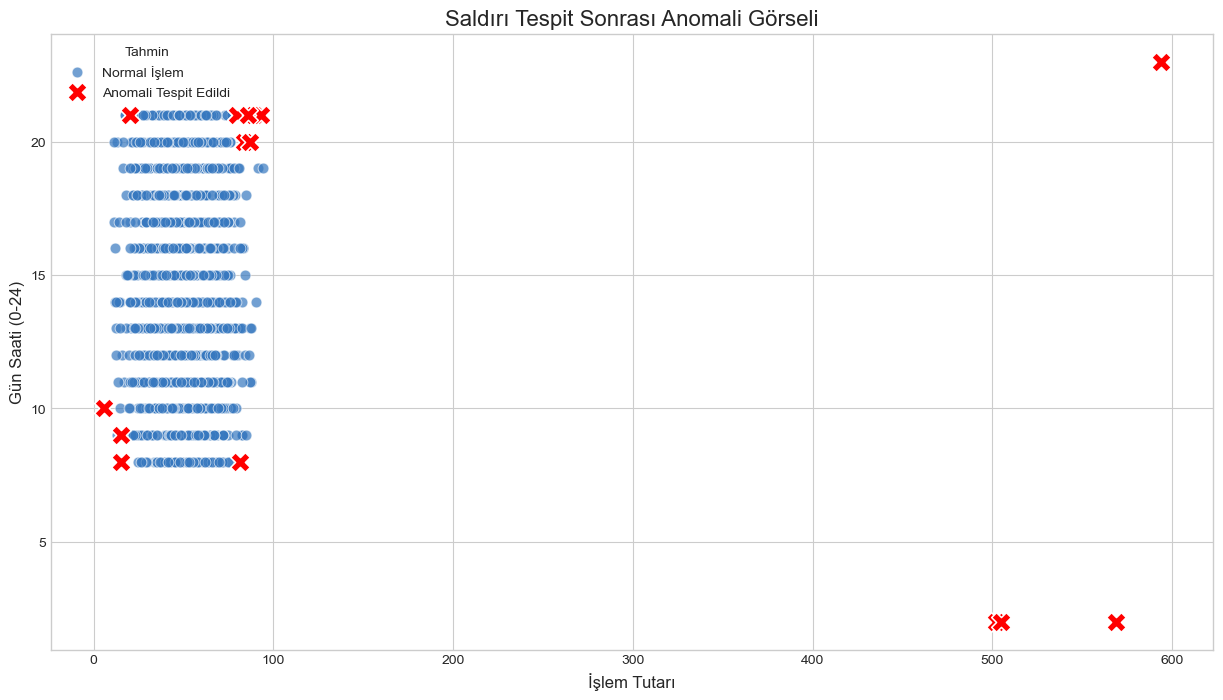


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:06
--- Anomali Detayları ---
      amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
3     502.22            2          209         1                  -1
476   504.91            2          202         1                  -1
724   593.59           23          209         1                  -1
802   569.02            2          208         1                  -1
2012  439.62           23          205         1                  -1


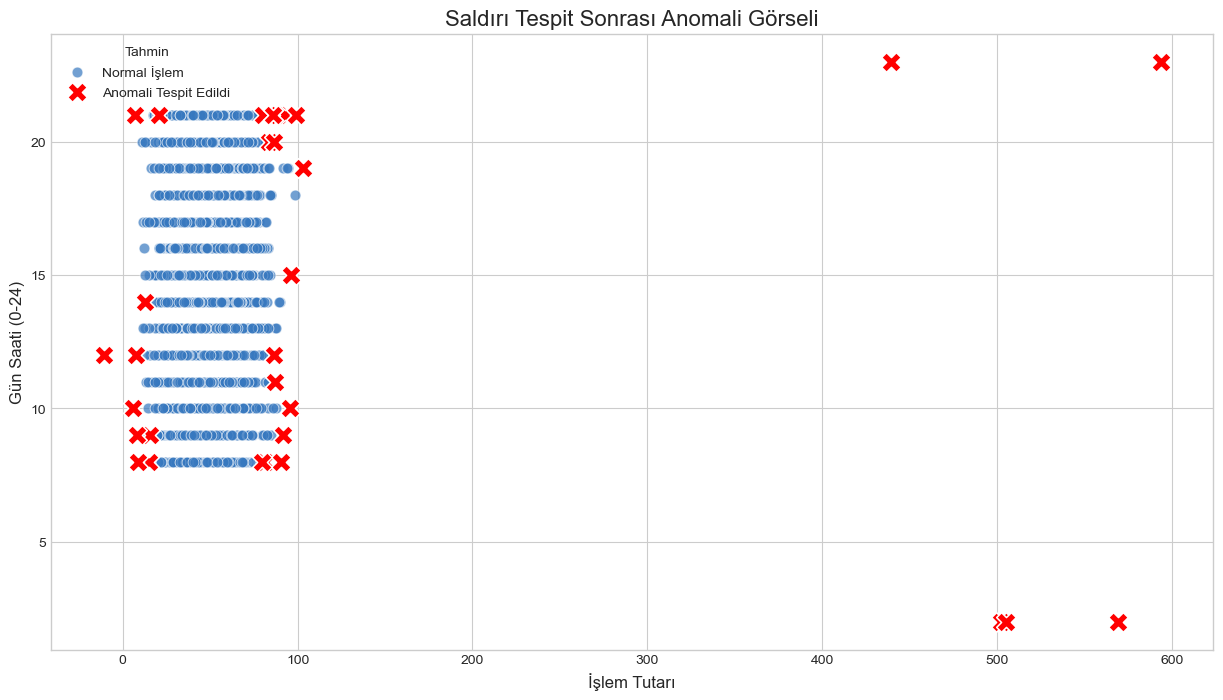


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:09
--- Anomali Detayları ---
      amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
3     502.22            2          209         1                  -1
476   504.91            2          202         1                  -1
724   593.59           23          209         1                  -1
802   569.02            2          208         1                  -1
2012  439.62           23          205         1                  -1
3266  441.01            2          203         1                  -1
3869  441.85            2          202         1                  -1


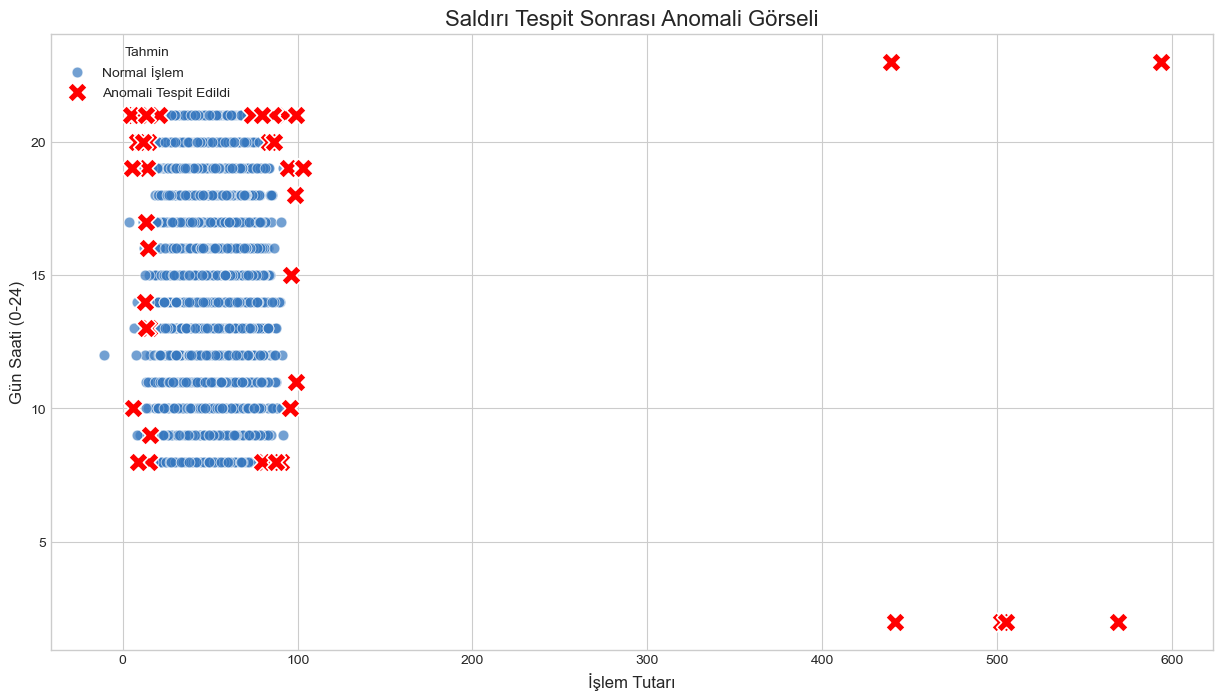


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:11
--- Anomali Detayları ---
      amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
2012  439.62           23          205         1                  -1
3266  441.01            2          203         1                  -1
3869  441.85            2          202         1                  -1
4969  423.48            2          205         1                  -1


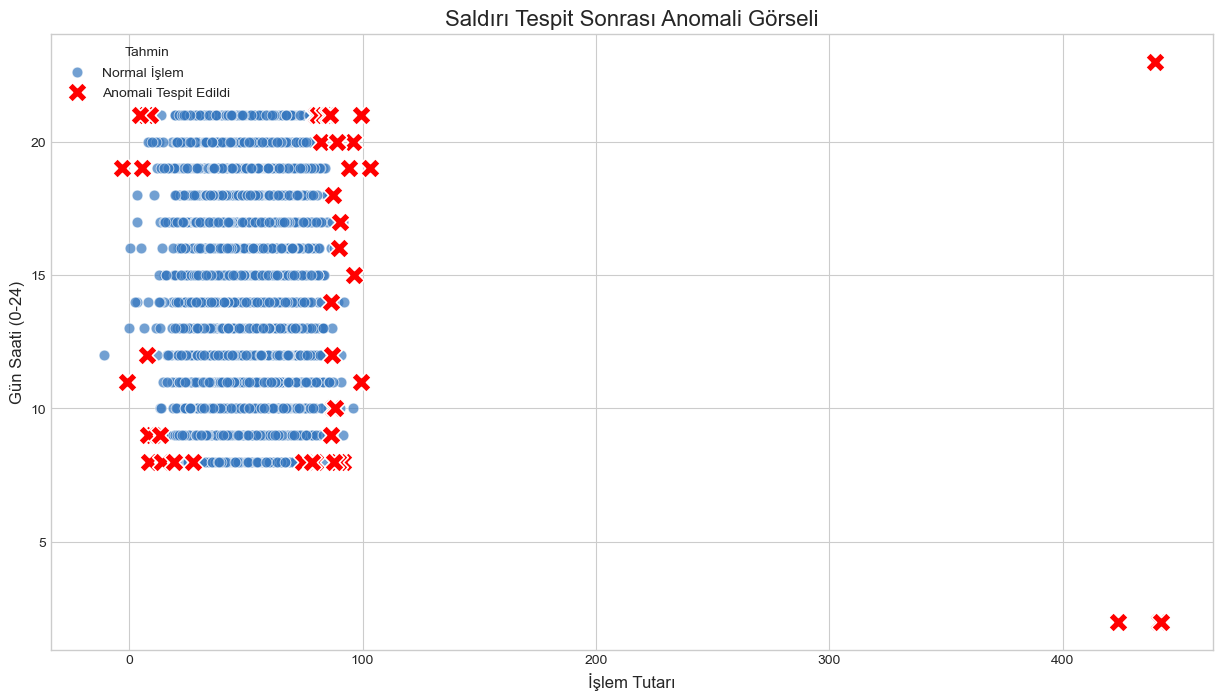


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:13
--- Anomali Detayları ---
      amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
3869  441.85            2          202         1                  -1
4969  423.48            2          205         1                  -1
6975  418.75           23          205         1                  -1
7365  643.38           23          203         1                  -1


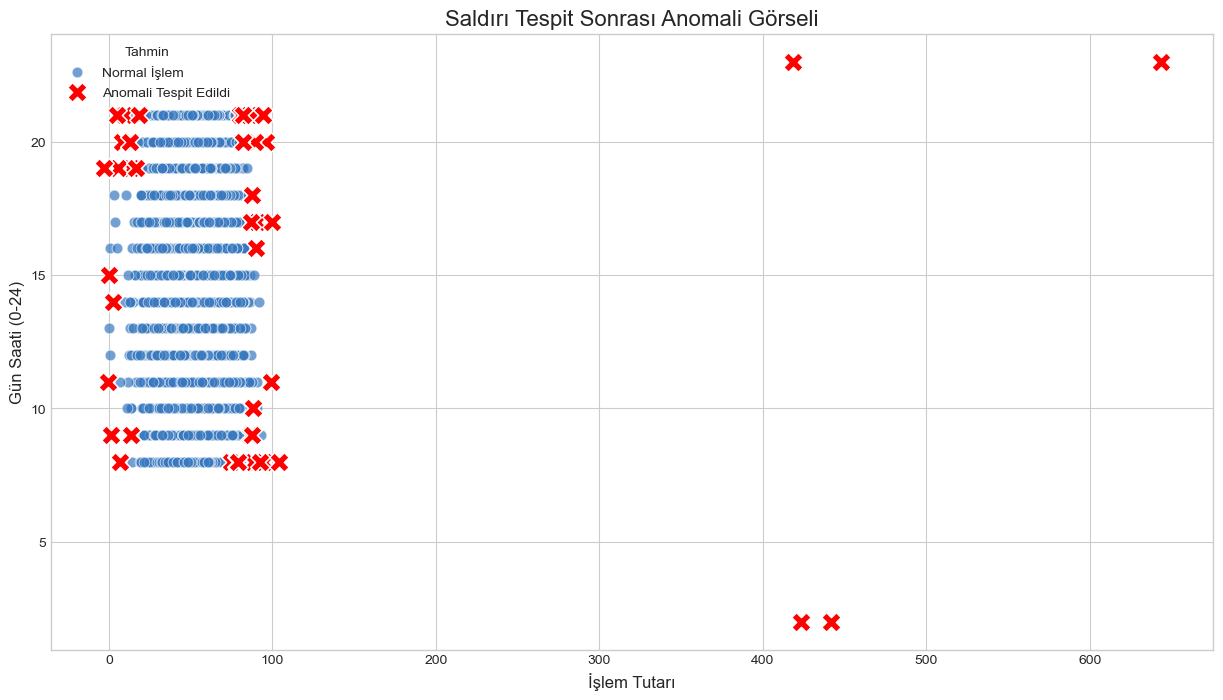


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:16
--- Anomali Detayları ---
      amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
6975  418.75           23          205         1                  -1
7365  643.38           23          203         1                  -1
8834  634.71           23          206         1                  -1
9009  510.50            2          205         1                  -1
9304  623.25            2          200         1                  -1


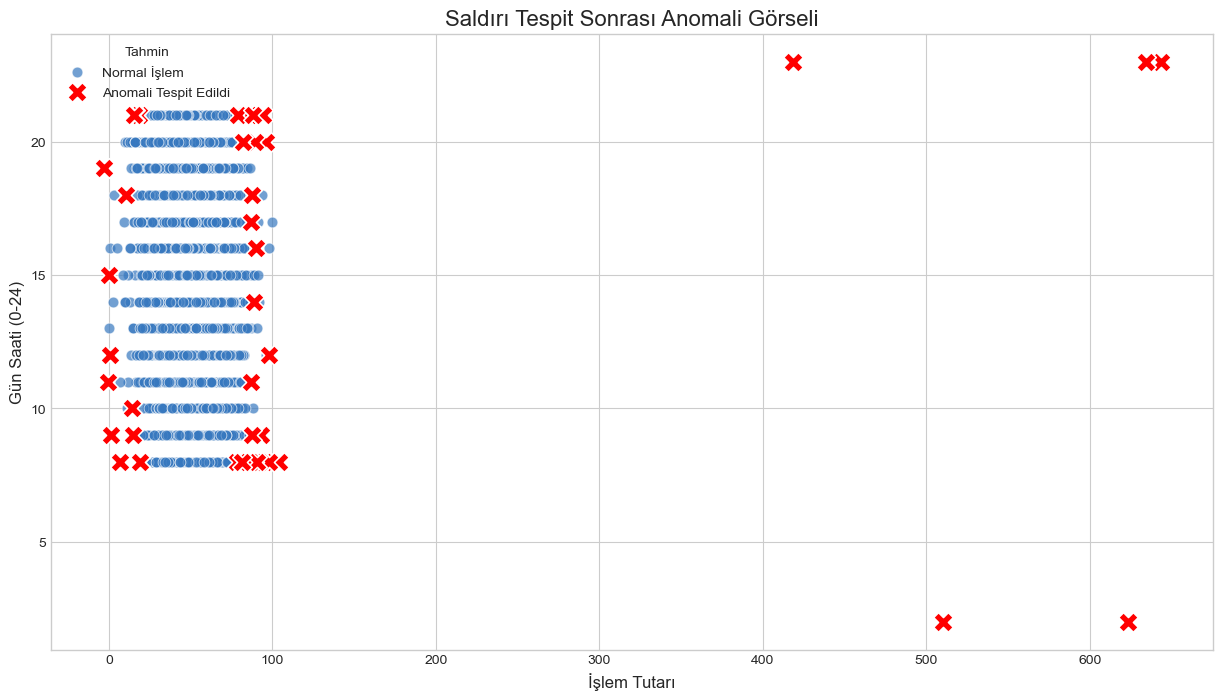


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:18
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
7365   643.38           23          203         1                  -1
8834   634.71           23          206         1                  -1
9009   510.50            2          205         1                  -1
9304   623.25            2          200         1                  -1
11461  403.62            2          201         1                  -1
11570  469.05           23          203         1                  -1


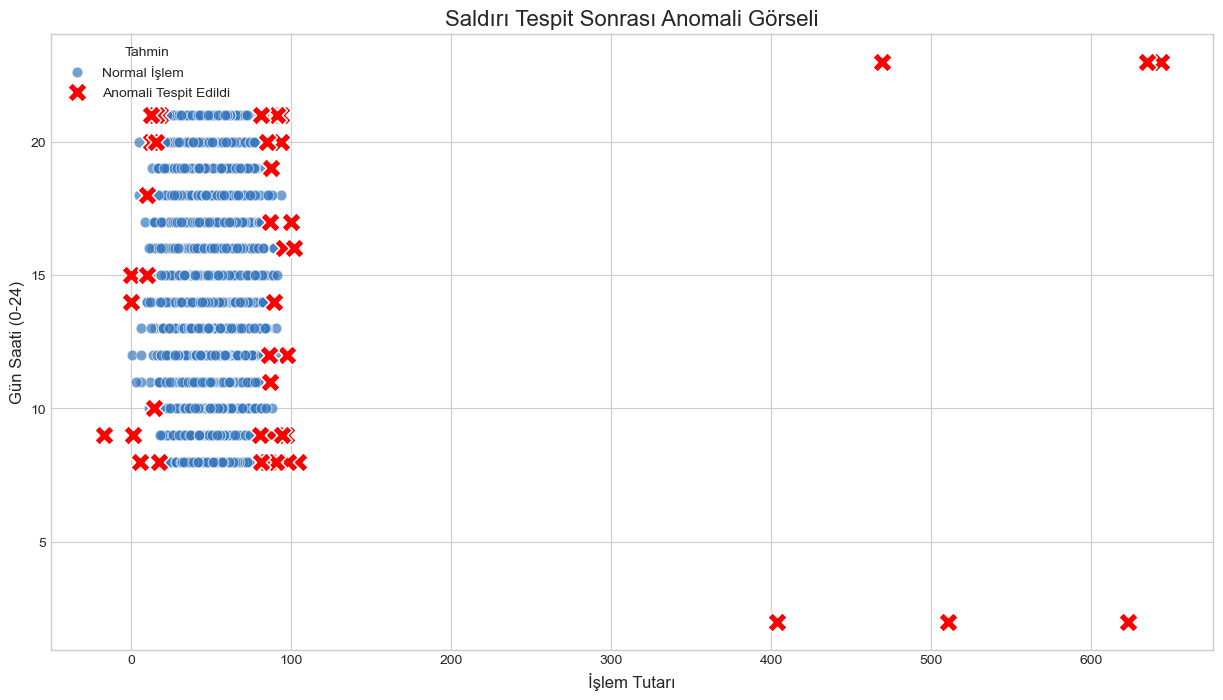


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:20
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
8834   634.71           23          206         1                  -1
9009   510.50            2          205         1                  -1
9304   623.25            2          200         1                  -1
11461  403.62            2          201         1                  -1
11570  469.05           23          203         1                  -1
13221  323.68            2          204         1                  -1


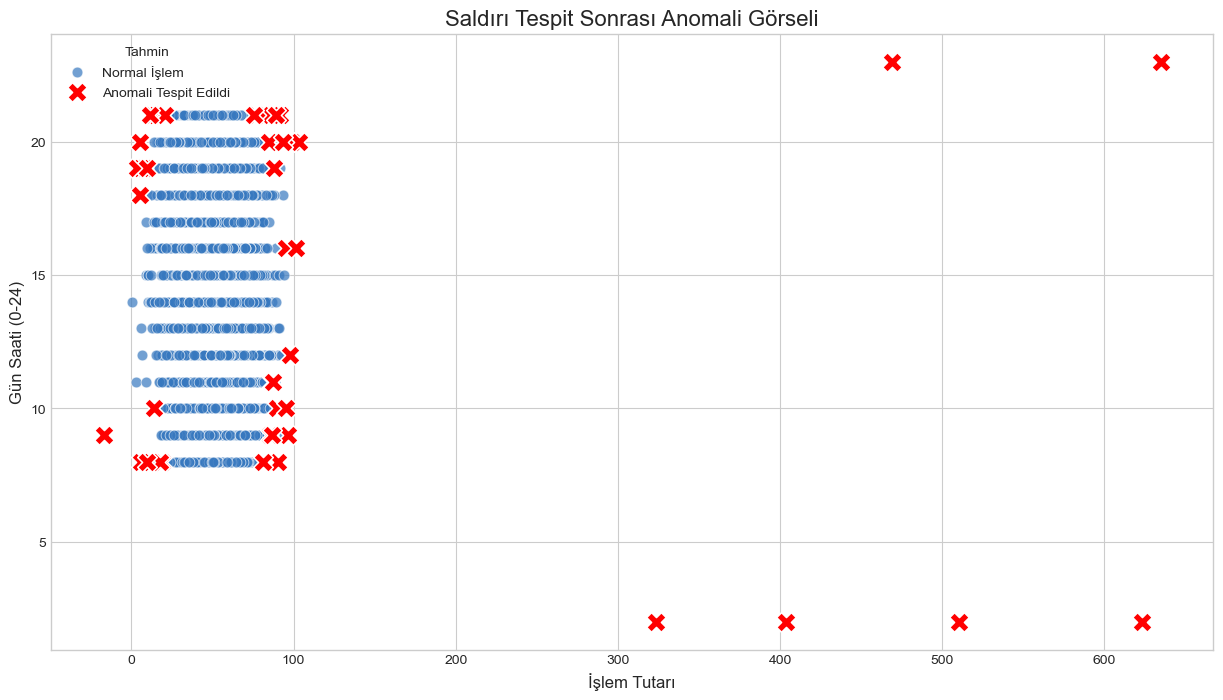


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:23
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
11461  403.62            2          201         1                  -1
11570  469.05           23          203         1                  -1
13221  323.68            2          204         1                  -1
13790  369.04           23          208         1                  -1
14339  396.03           23          204         1                  -1
15461  432.06           23          205         1                  -1


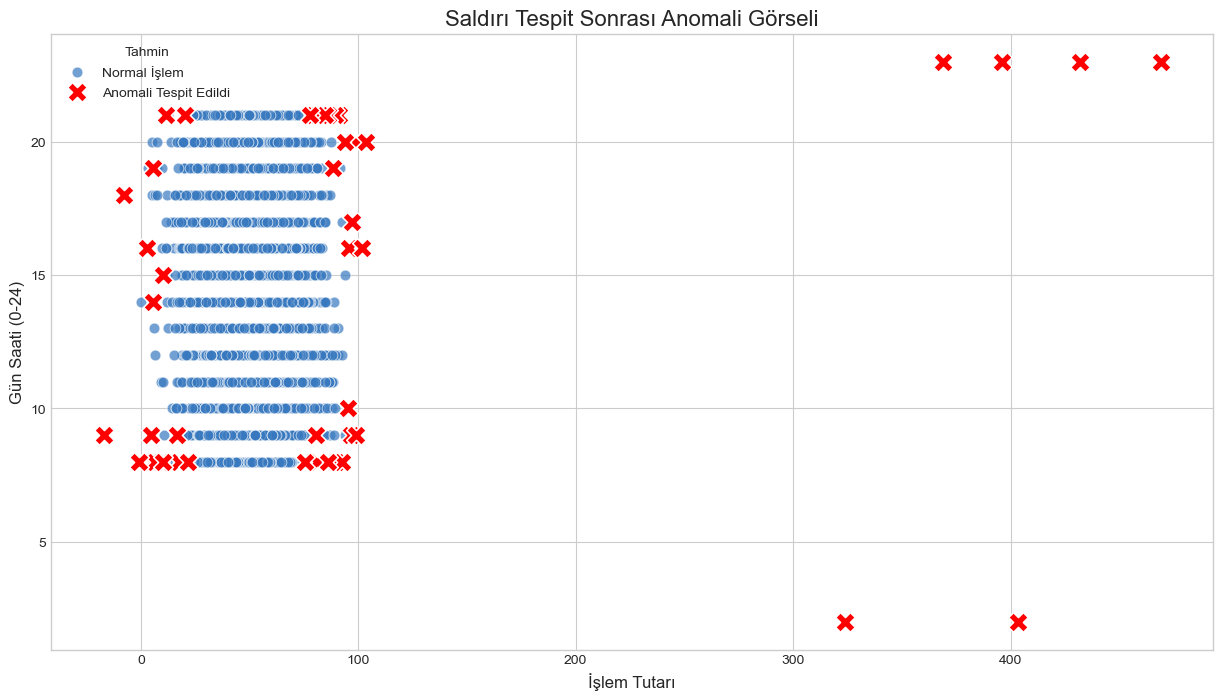


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:25
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
13221  323.68            2          204         1                  -1
13790  369.04           23          208         1                  -1
14339  396.03           23          204         1                  -1
15461  432.06           23          205         1                  -1
16433  581.54            2          203         1                  -1
16770  605.28            2          201         1                  -1


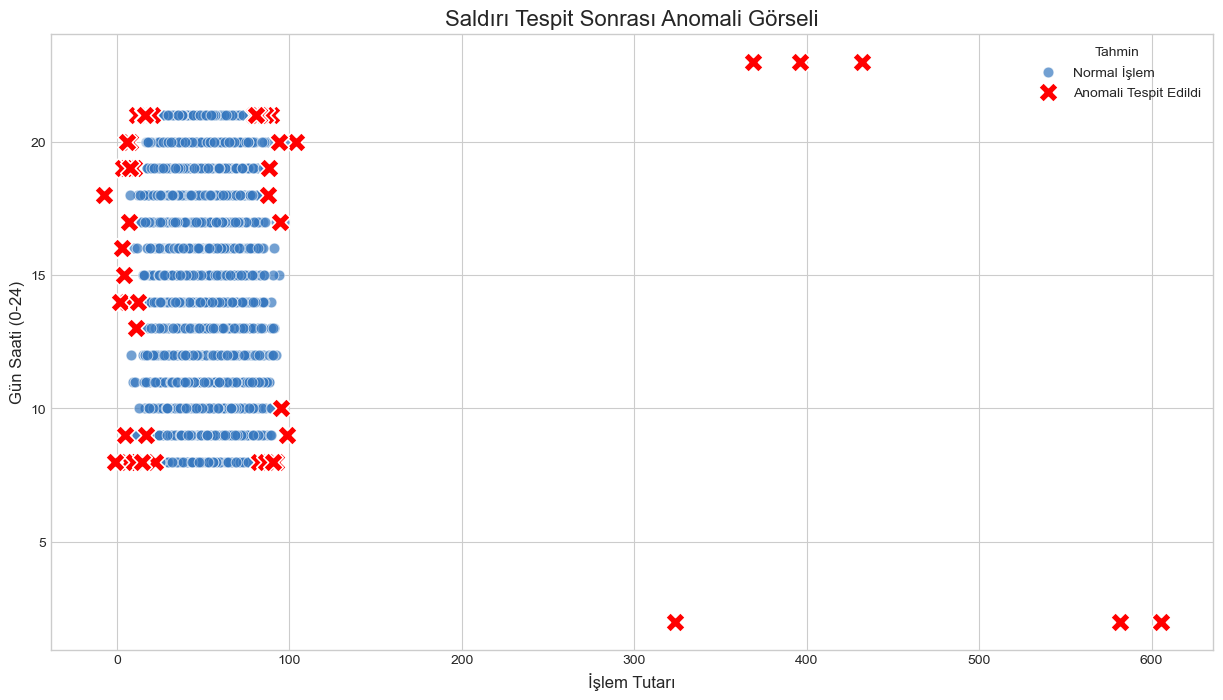


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:27
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
14339  396.03           23          204         1                  -1
15461  432.06           23          205         1                  -1
16433  581.54            2          203         1                  -1
16770  605.28            2          201         1                  -1


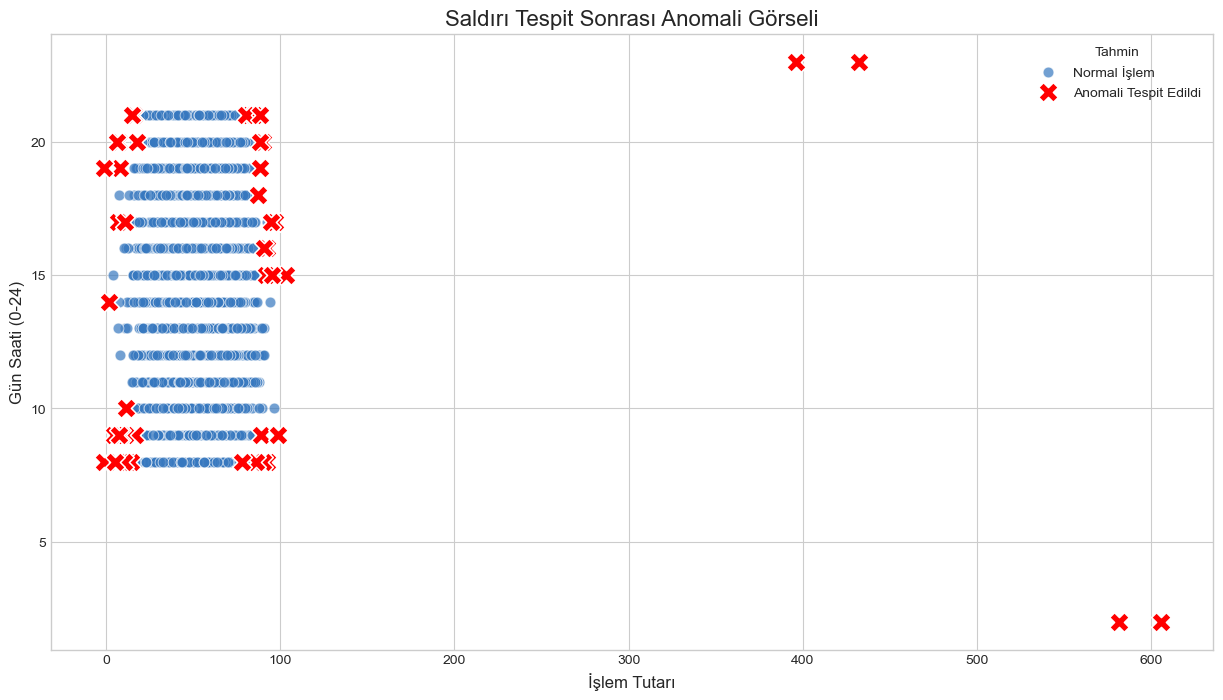


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:30
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
16433  581.54            2          203         1                  -1
16770  605.28            2          201         1                  -1


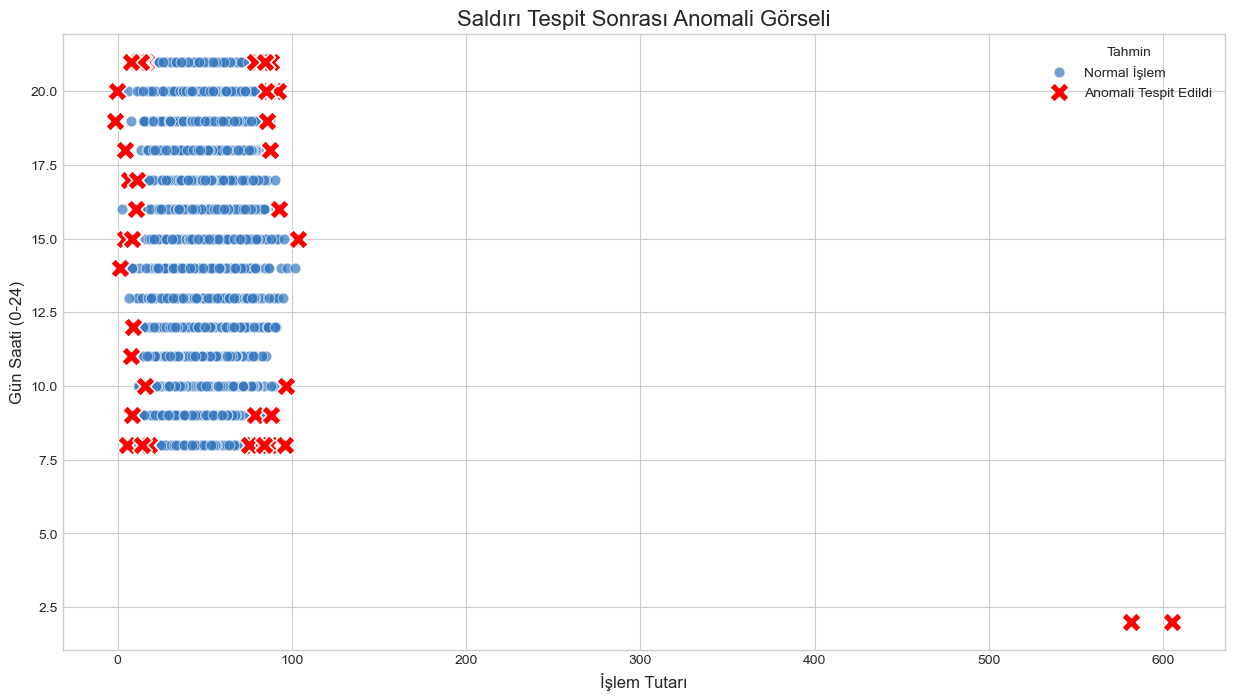


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:32
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
21093  417.13           23          201         1                  -1
22498  454.68            2          206         1                  -1


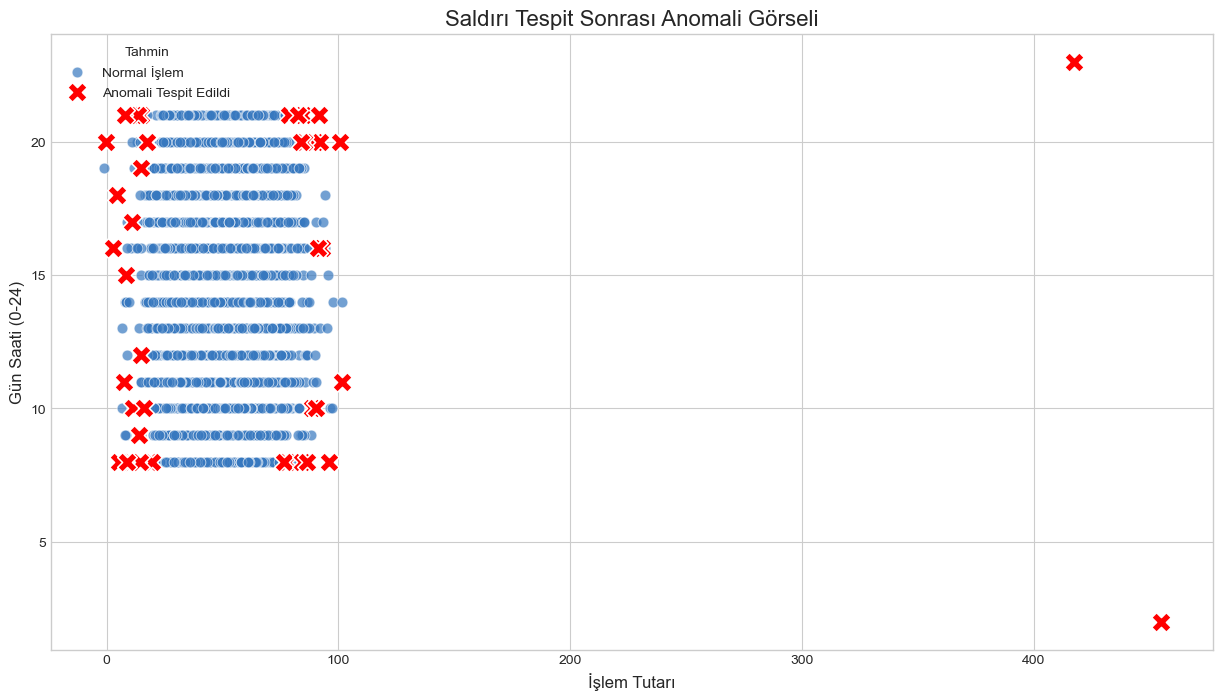


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:34
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
21093  417.13           23          201         1                  -1
22498  454.68            2          206         1                  -1
23473  434.07            2          201         1                  -1
24014  490.35           23          204         1                  -1


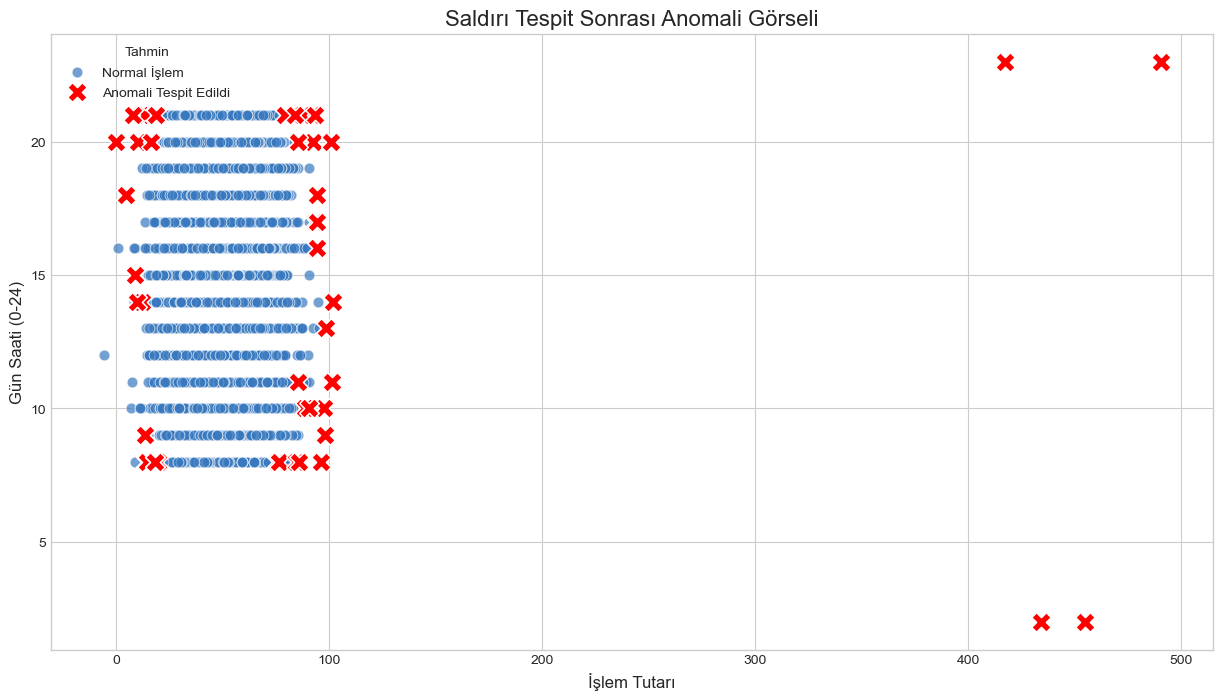


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:37
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
21093  417.13           23          201         1                  -1
22498  454.68            2          206         1                  -1
23473  434.07            2          201         1                  -1
24014  490.35           23          204         1                  -1
24483  535.90            2          207         1                  -1
25327  671.92           23          208         1                  -1
25685  361.42           23          206         1                  -1


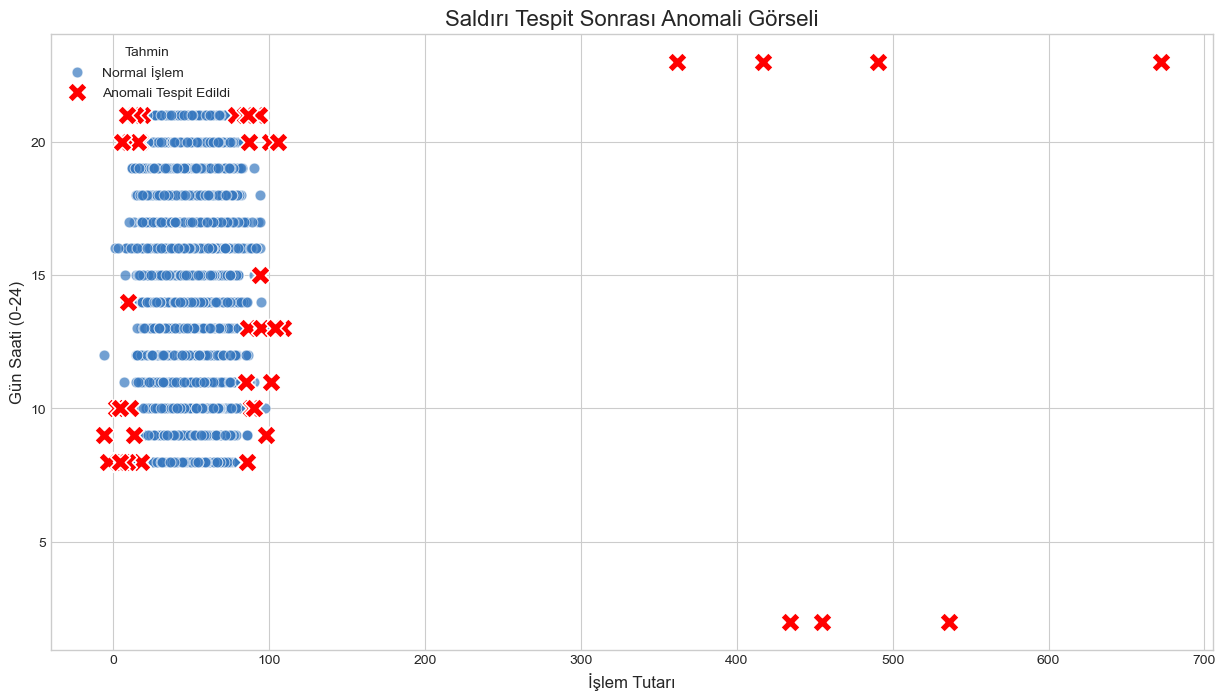


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:39
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
23473  434.07            2          201         1                  -1
24014  490.35           23          204         1                  -1
24483  535.90            2          207         1                  -1
25327  671.92           23          208         1                  -1
25685  361.42           23          206         1                  -1
26092  443.88            2          206         1                  -1
26190  533.41            2          201         1                  -1
26514  444.41           23          209         1                  -1


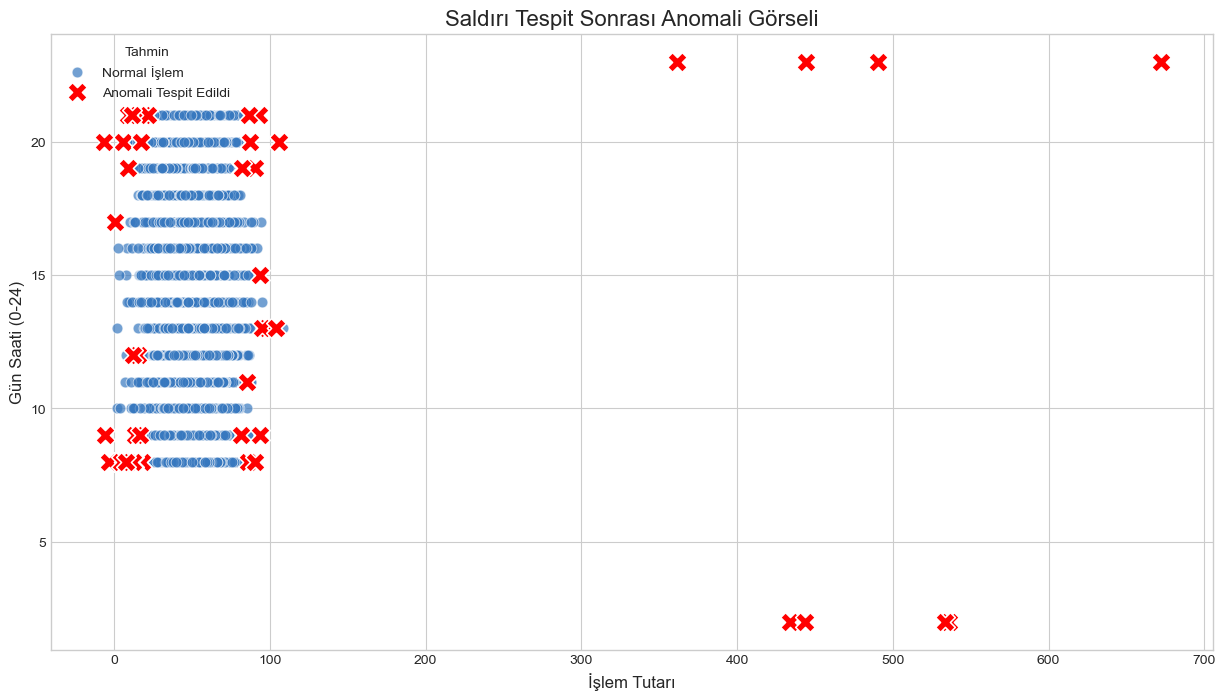


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:41
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
25327  671.92           23          208         1                  -1
25685  361.42           23          206         1                  -1
26092  443.88            2          206         1                  -1
26190  533.41            2          201         1                  -1
26514  444.41           23          209         1                  -1
28258  337.86            2          205         1                  -1
29242  698.37           23          203         1                  -1


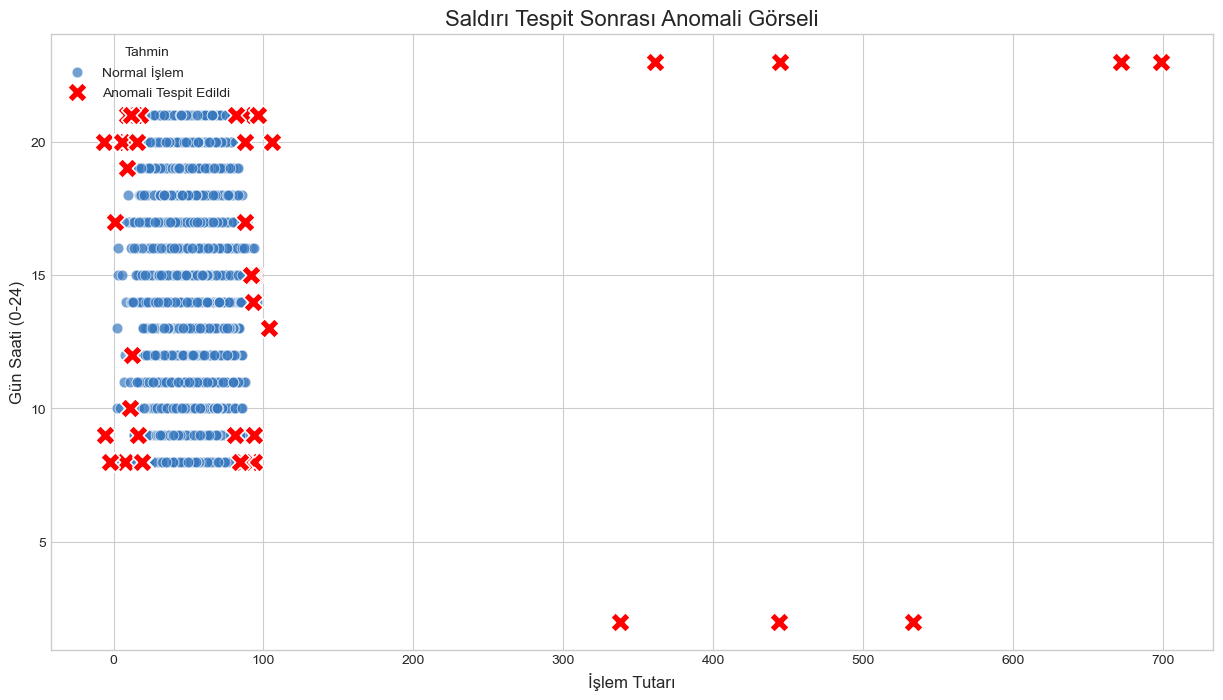


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:44
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
26514  444.41           23          209         1                  -1
28258  337.86            2          205         1                  -1
29242  698.37           23          203         1                  -1
30928  425.38           23          209         1                  -1


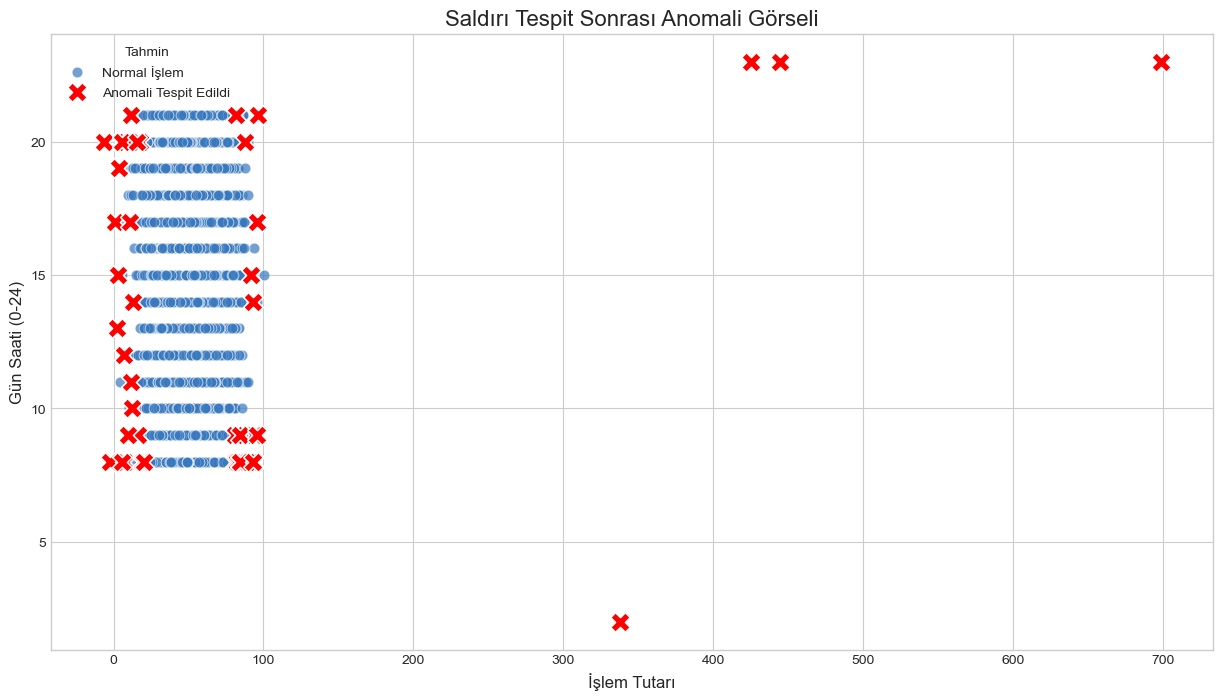


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:46
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
28258  337.86            2          205         1                  -1
29242  698.37           23          203         1                  -1
30928  425.38           23          209         1                  -1
31937  536.44            2          205         1                  -1
31977  586.30            2          204         1                  -1


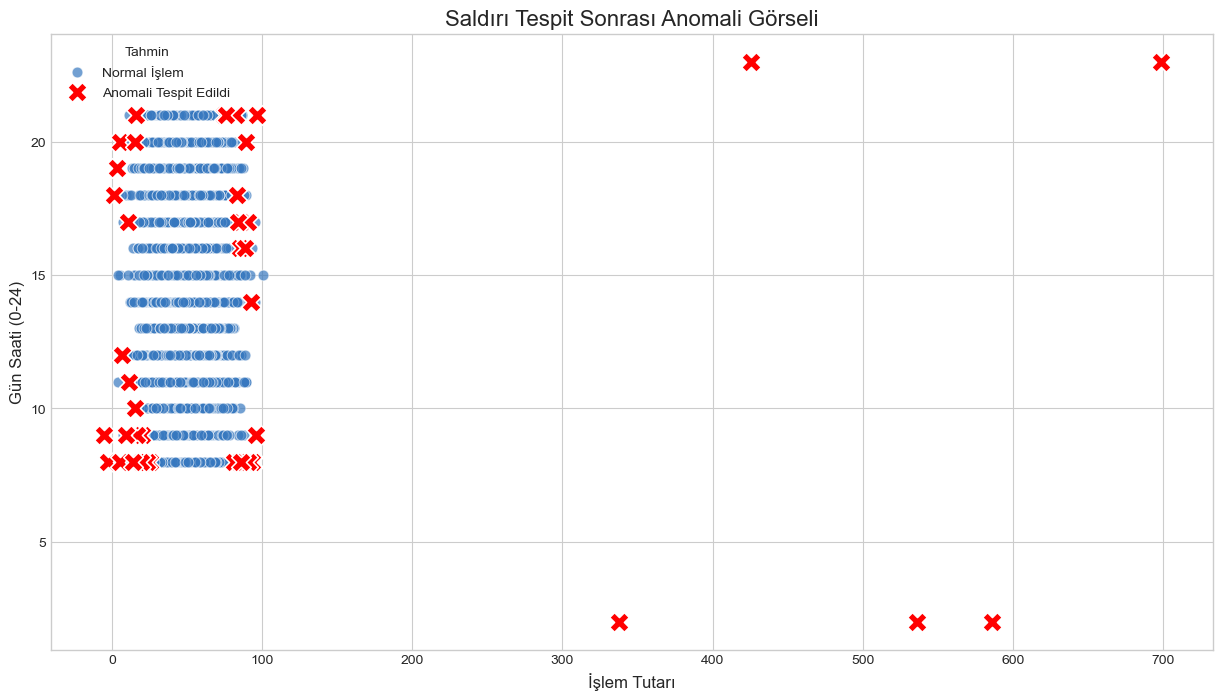


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:48
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
30928  425.38           23          209         1                  -1
31937  536.44            2          205         1                  -1
31977  586.30            2          204         1                  -1
33758  466.44            2          207         1                  -1
34130  548.31           23          202         1                  -1
34629  516.17            2          204         1                  -1


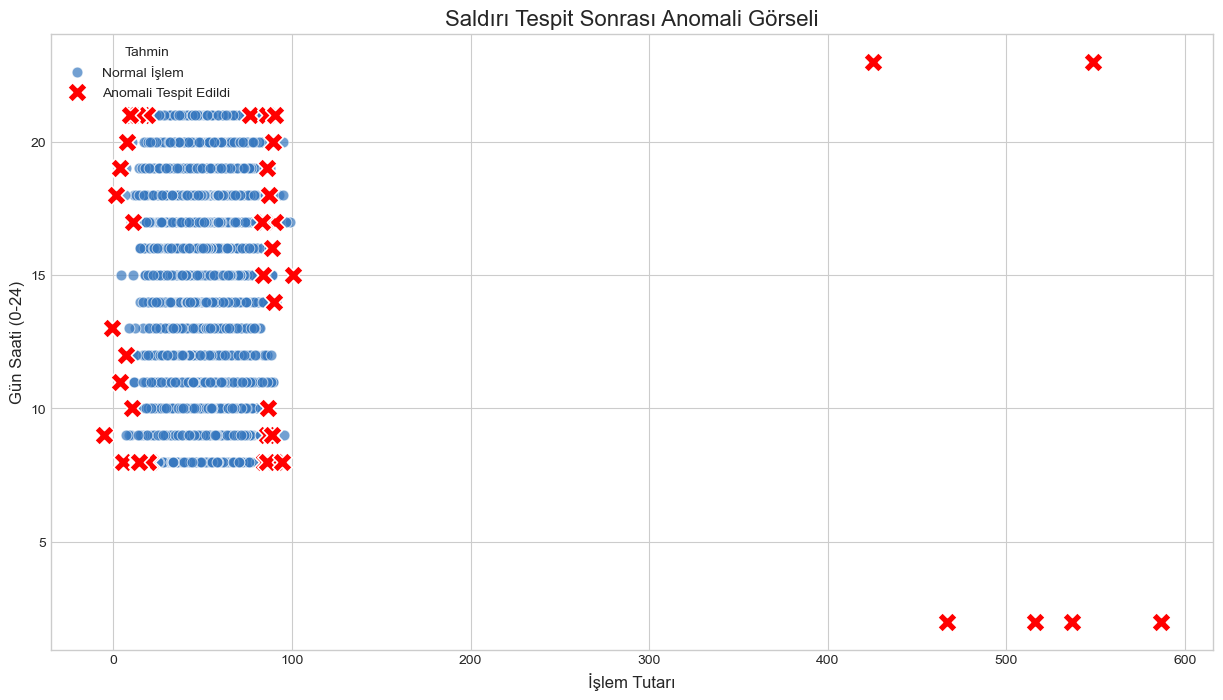


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:51
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
31937  536.44            2          205         1                  -1
31977  586.30            2          204         1                  -1
33758  466.44            2          207         1                  -1
34130  548.31           23          202         1                  -1
34629  516.17            2          204         1                  -1
36210  499.39            2          204         1                  -1


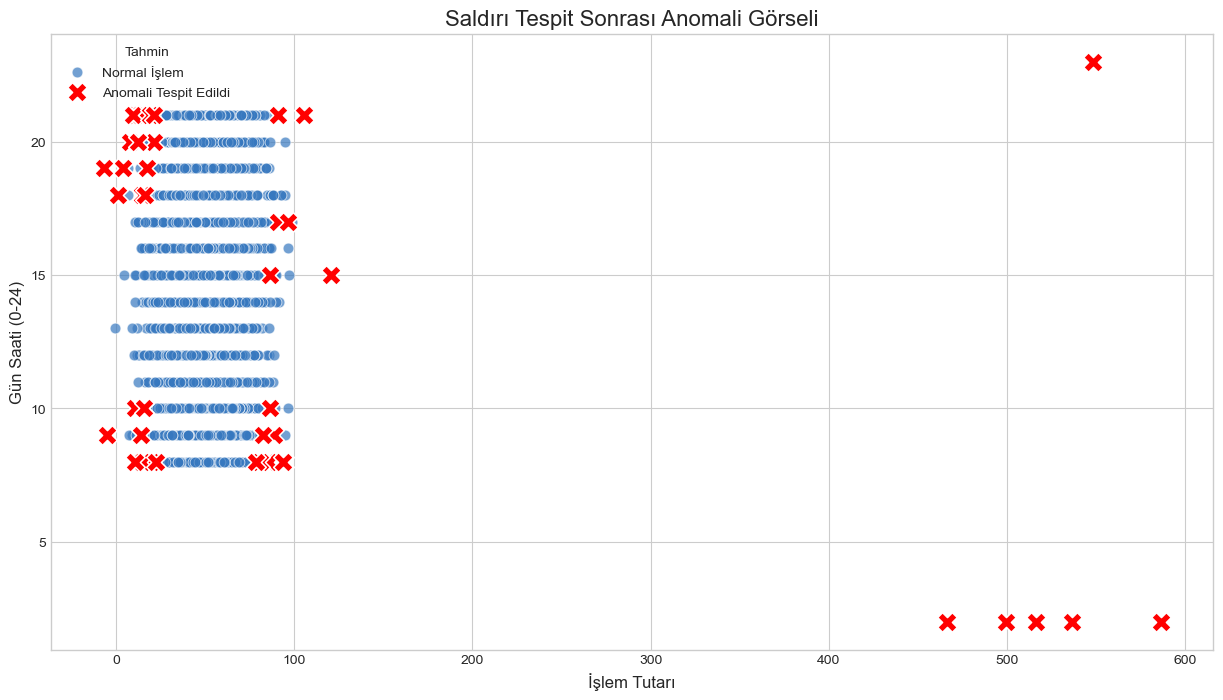


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:53
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
33758  466.44            2          207         1                  -1
34130  548.31           23          202         1                  -1
34629  516.17            2          204         1                  -1
36210  499.39            2          204         1                  -1
37419  426.92            2          202         1                  -1


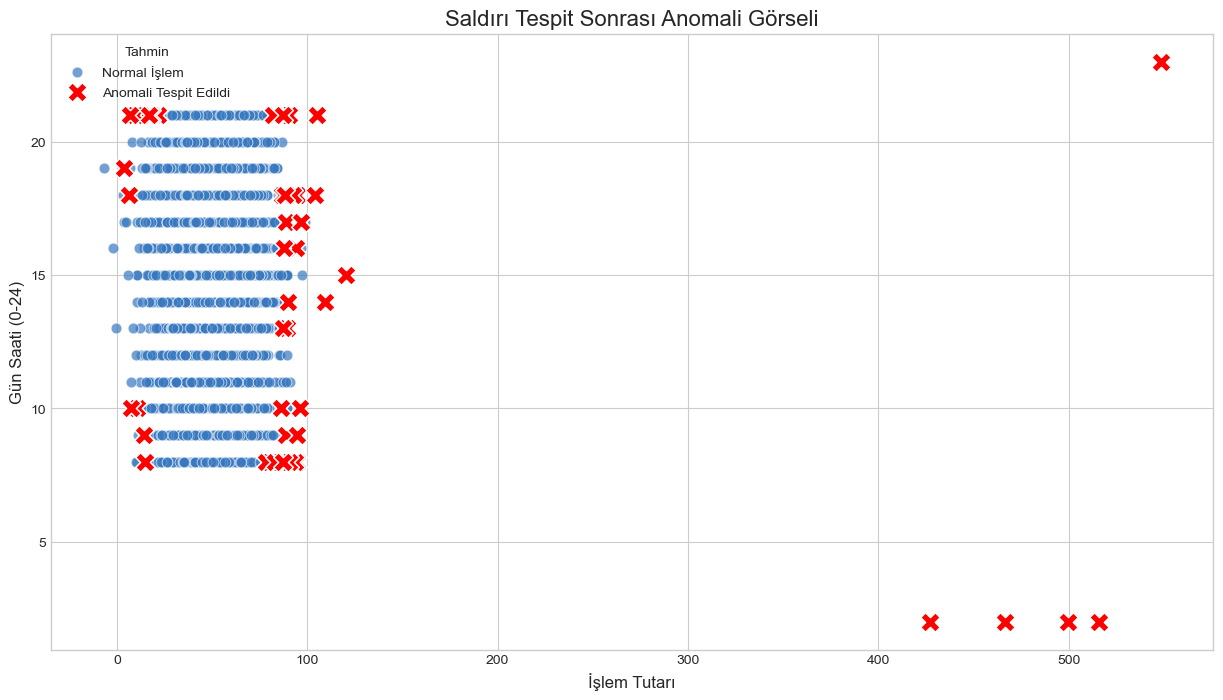


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:55
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
36210  499.39            2          204         1                  -1
37419  426.92            2          202         1                  -1


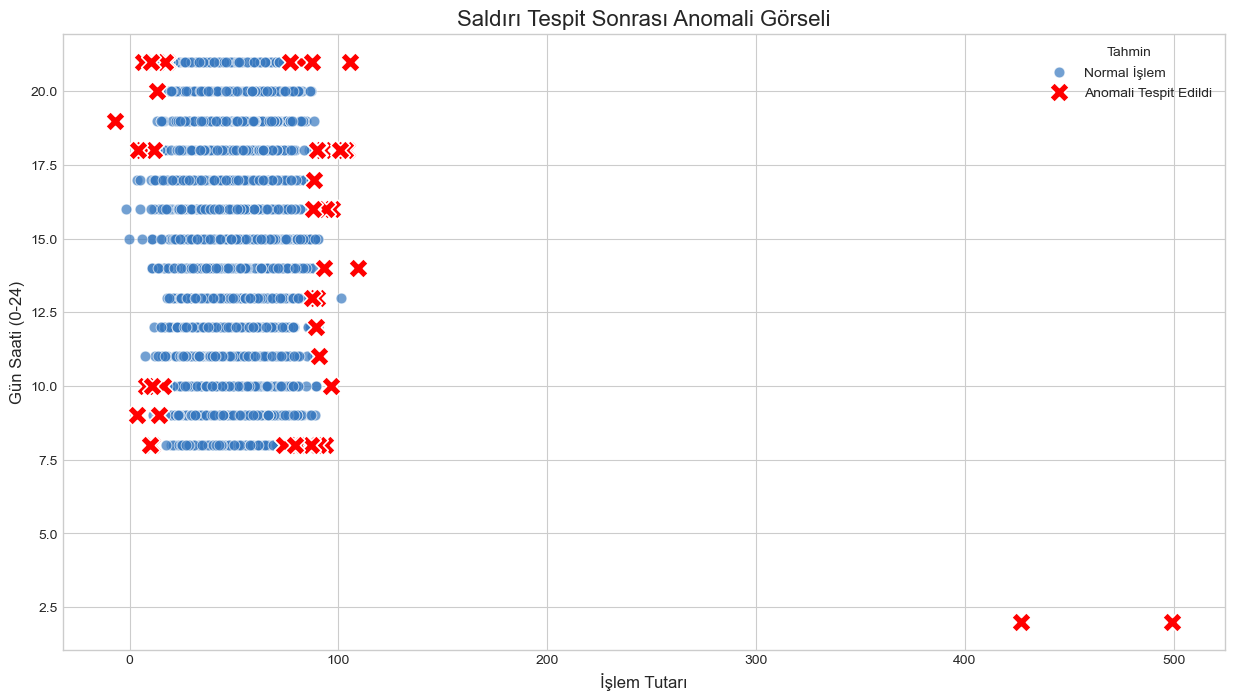


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:19:58
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
37419  426.92            2          202         1                  -1


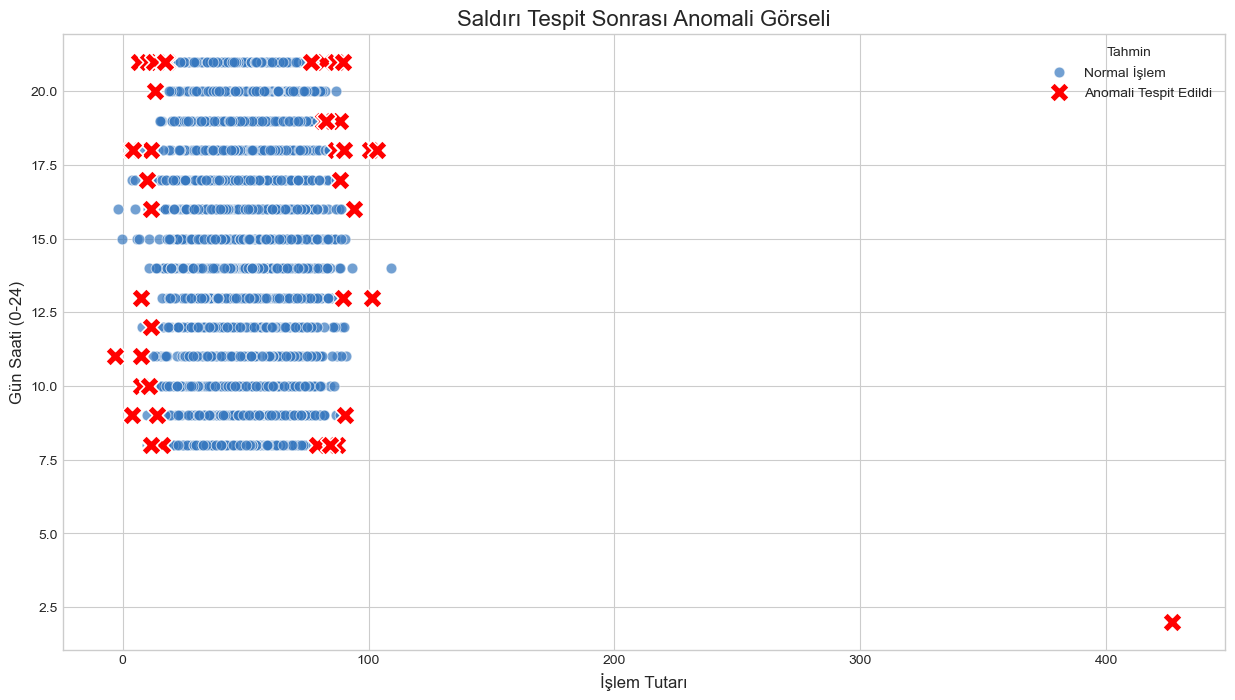


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:00
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
42966  490.61            2          202         1                  -1
43144  483.28           23          206         1                  -1


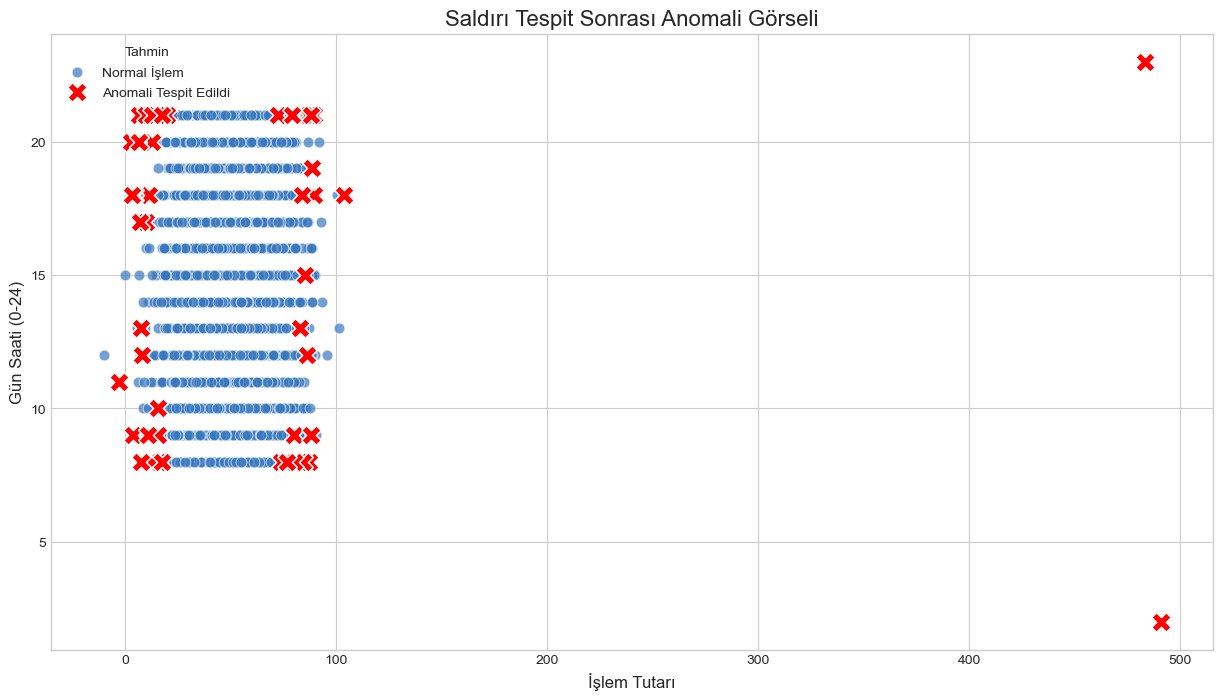


!!! RAM SCRAPING SALDIRISI BAŞLADI !!!

!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:02
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
42966  490.61            2          202         1                  -1
43144  483.28           23          206         1                  -1
44780  531.11            2          203         1                  -1
45348  531.40            2          208         1                  -1


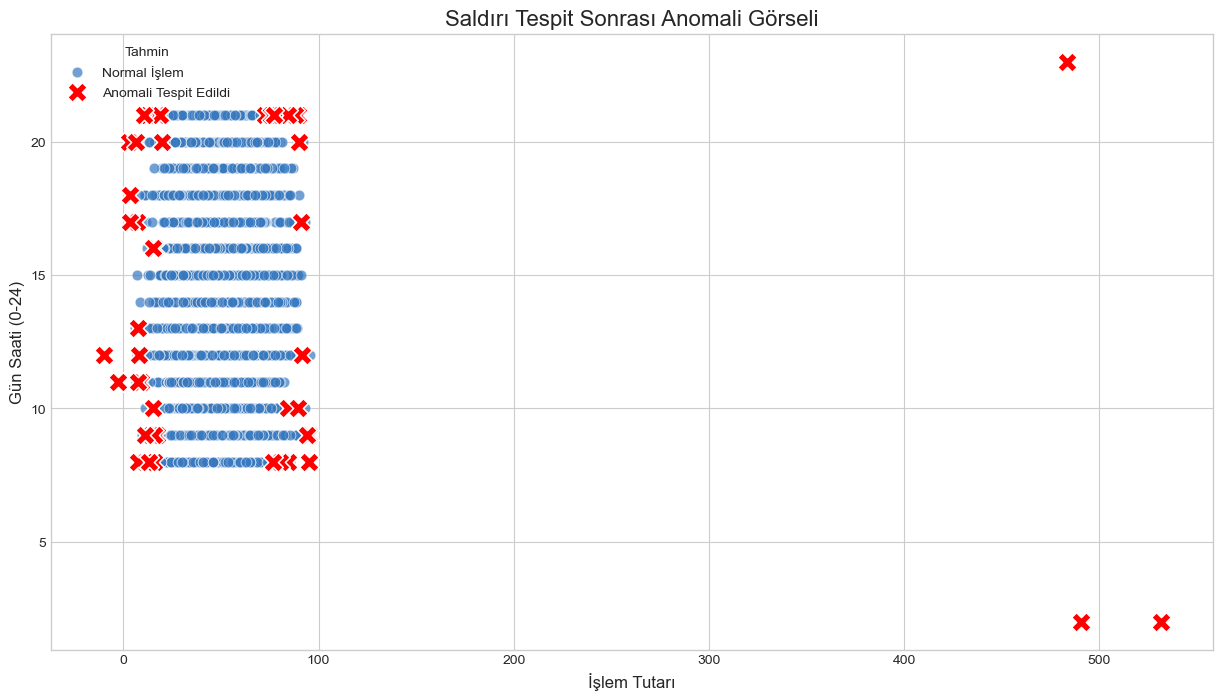


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:05
--- Anomali Detayları ---
            amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
42966   490.610000            2          202         1                  -1
43144   483.280000           23          206         1                  -1
44780   531.110000            2          203         1                  -1
45348   531.400000            2          208         1                  -1
45384  1638.236198           13          105         1                  -1
45420  1297.321598           14          105         1                  -1
45462  1644.535572           14          105         1                  -1
45506  1584.210999           11          105         1                  -1
45539  1411.002602           10          105         1                  -1
45561  1667.602886           14          105         1                  -1
45590  1451.160178           12          105         1              

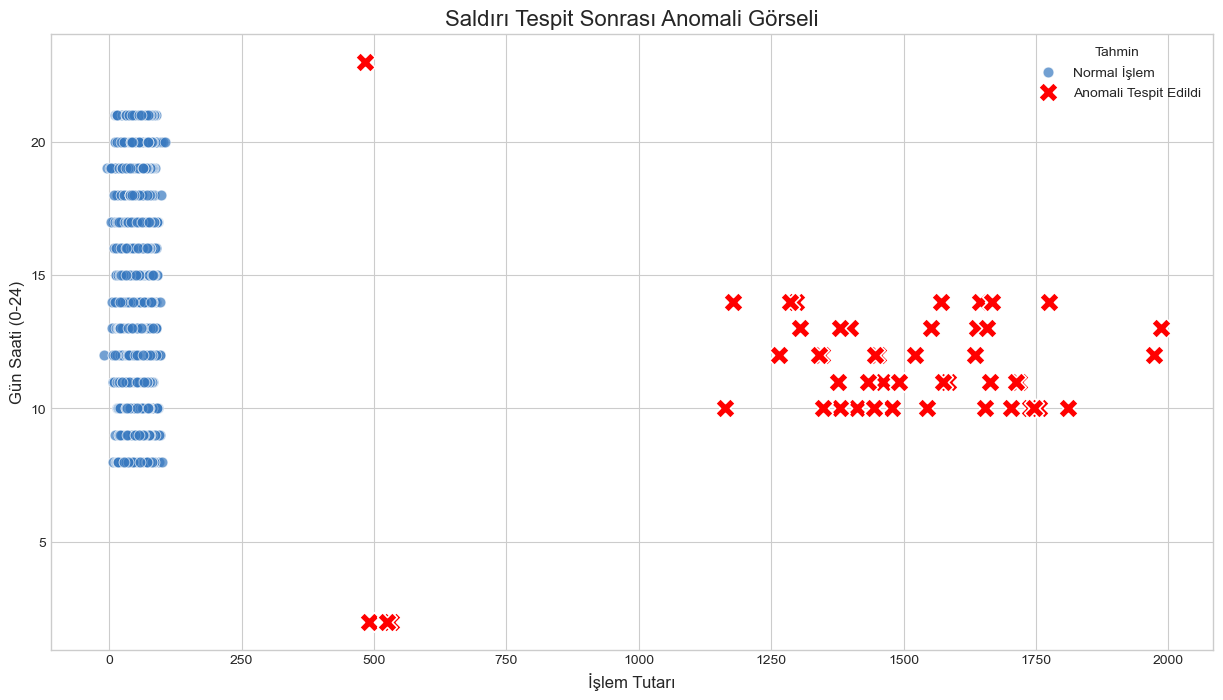


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:07
--- Anomali Detayları ---
            amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
44780   531.110000            2          203         1                  -1
45348   531.400000            2          208         1                  -1
45384  1638.236198           13          105         1                  -1
45420  1297.321598           14          105         1                  -1
45462  1644.535572           14          105         1                  -1
45506  1584.210999           11          105         1                  -1
45539  1411.002602           10          105         1                  -1
45561  1667.602886           14          105         1                  -1
45590  1451.160178           12          105         1                  -1
45631  1461.809647           11          105         1                  -1
45718  1550.828190           13          105         1              

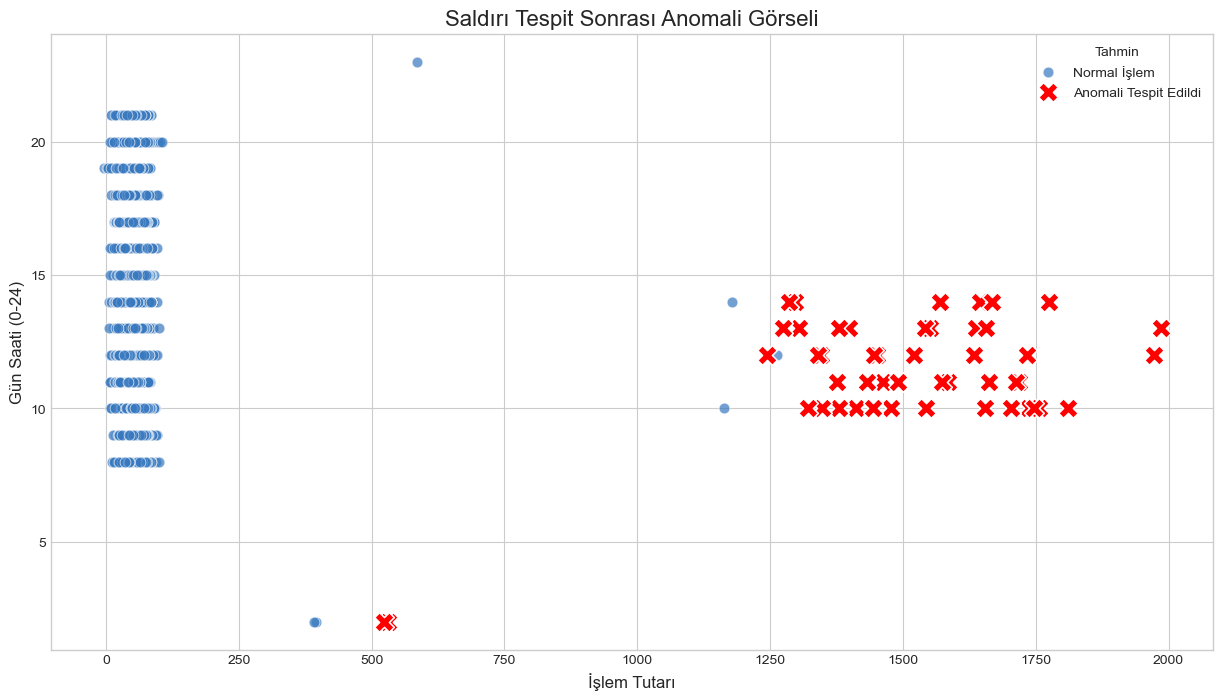


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:09
--- Anomali Detayları ---
            amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
45762  1478.481113           10          105         1                  -1
45806  1490.697913           11          105         1                  -1
45846  1717.773737           11          105         1                  -1
45888  1738.215103           10          105         1                  -1
45932  1712.558717           11          105         1                  -1
45976  1756.010676           10          105         1                  -1
46020  1703.337160           10          105         1                  -1
46064  1285.512500           14          105         1                  -1
46108  1569.641034           14          105         1                  -1
46149  1342.582841           12          105         1                  -1
46189  1653.673323           10          105         1              

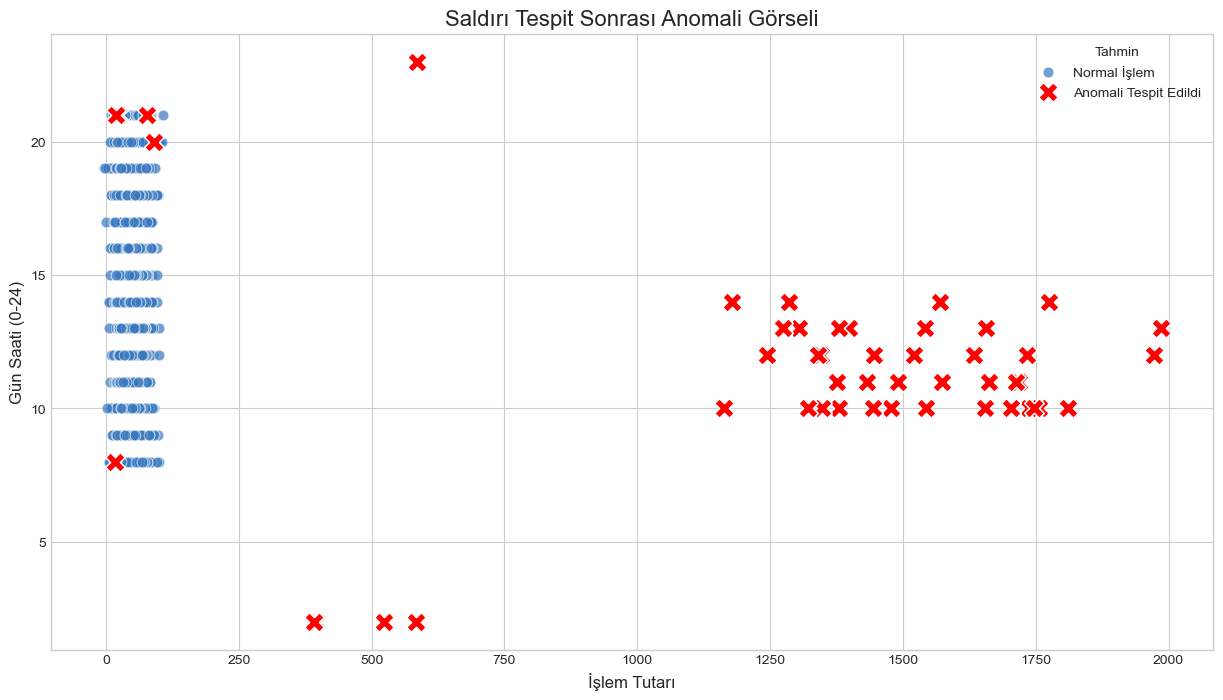


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:12
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
47961  390.98            2          201         1                  -1
50367  583.10            2          202         1                  -1
50809  406.21           23          209         1                  -1
51160  500.17            2          208         1                  -1


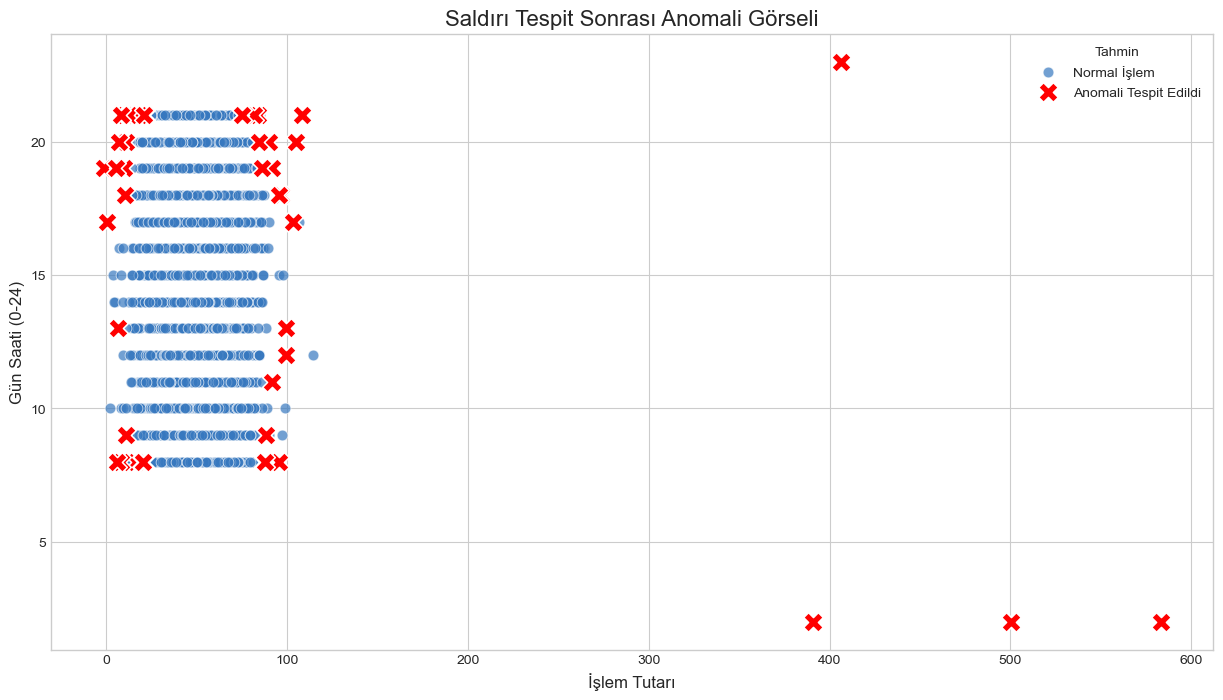


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:14
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
50367  583.10            2          202         1                  -1
50809  406.21           23          209         1                  -1
51160  500.17            2          208         1                  -1
53264  653.92           23          206         1                  -1
53873  614.49           23          200         1                  -1


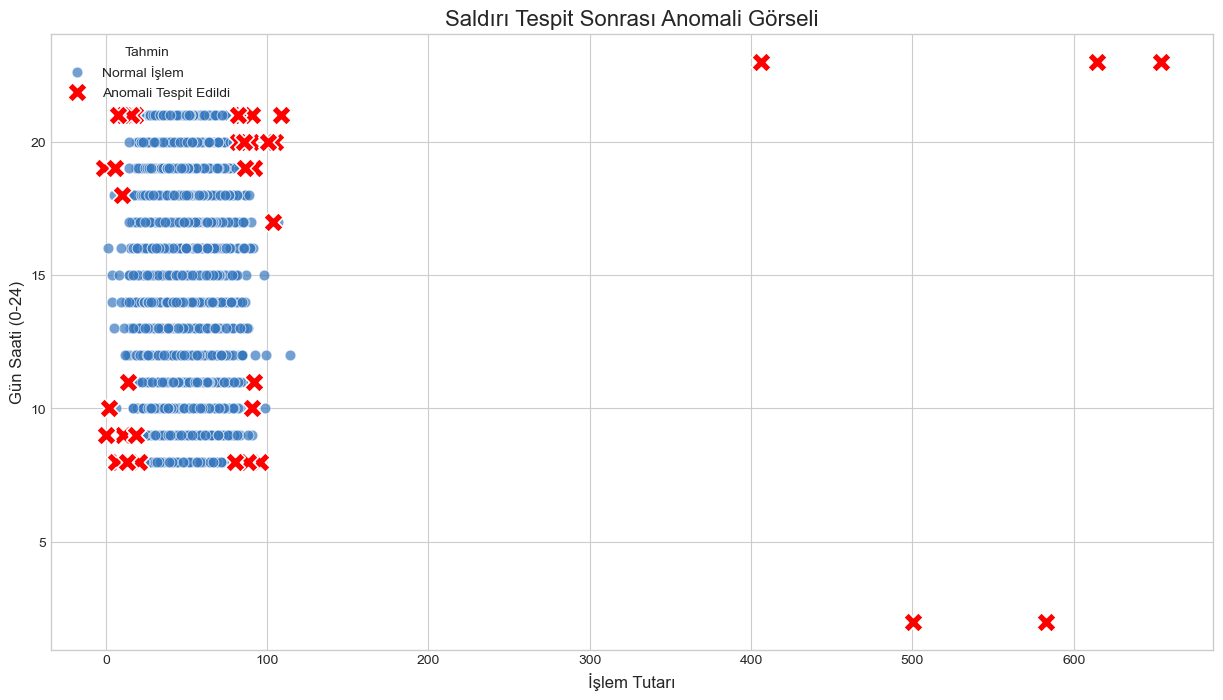


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:16
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
51160  500.17            2          208         1                  -1
53264  653.92           23          206         1                  -1
53873  614.49           23          200         1                  -1


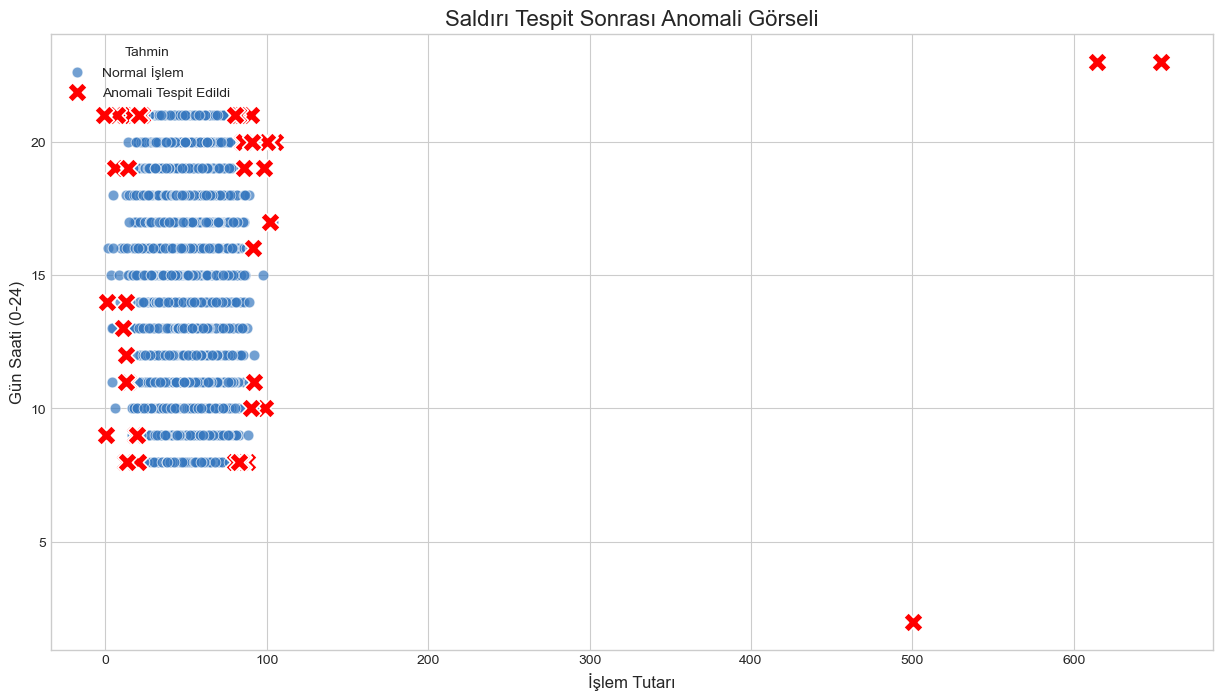


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:19
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
53264  653.92           23          206         1                  -1
53873  614.49           23          200         1                  -1
56856  621.33           23          203         1                  -1
57312  375.70           23          202         1                  -1


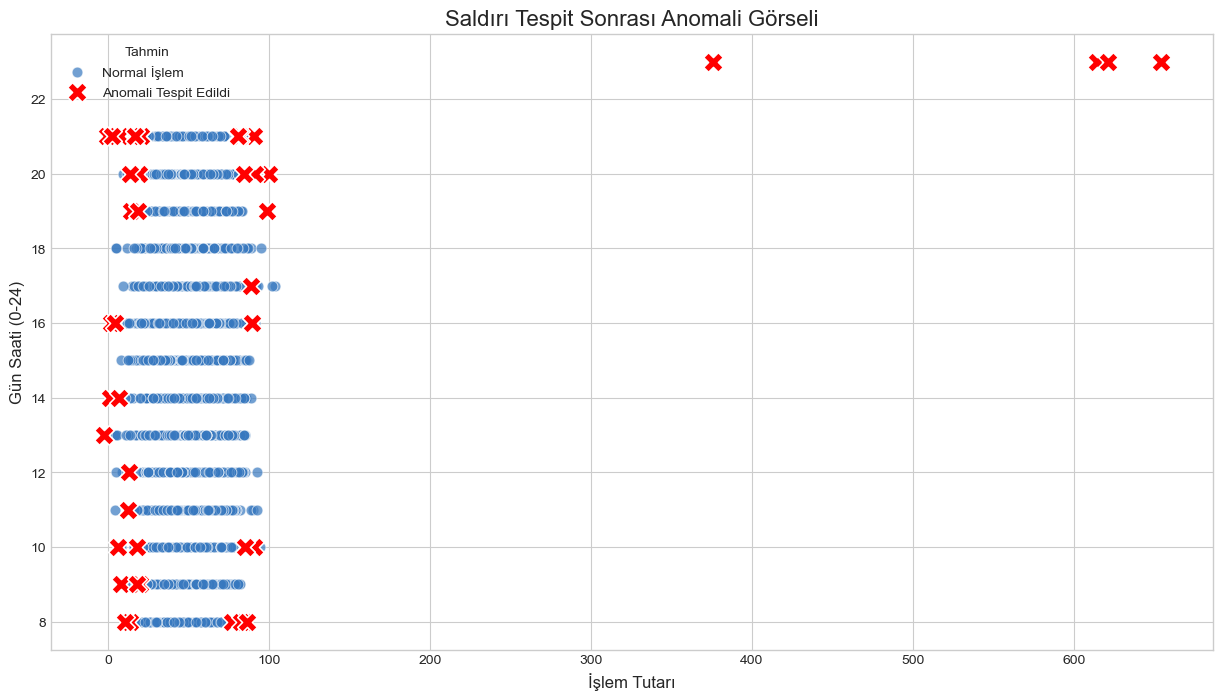


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:21
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
56856  621.33           23          203         1                  -1
57312  375.70           23          202         1                  -1
57890  429.03           23          203         1                  -1
58553  410.83           23          201         1                  -1


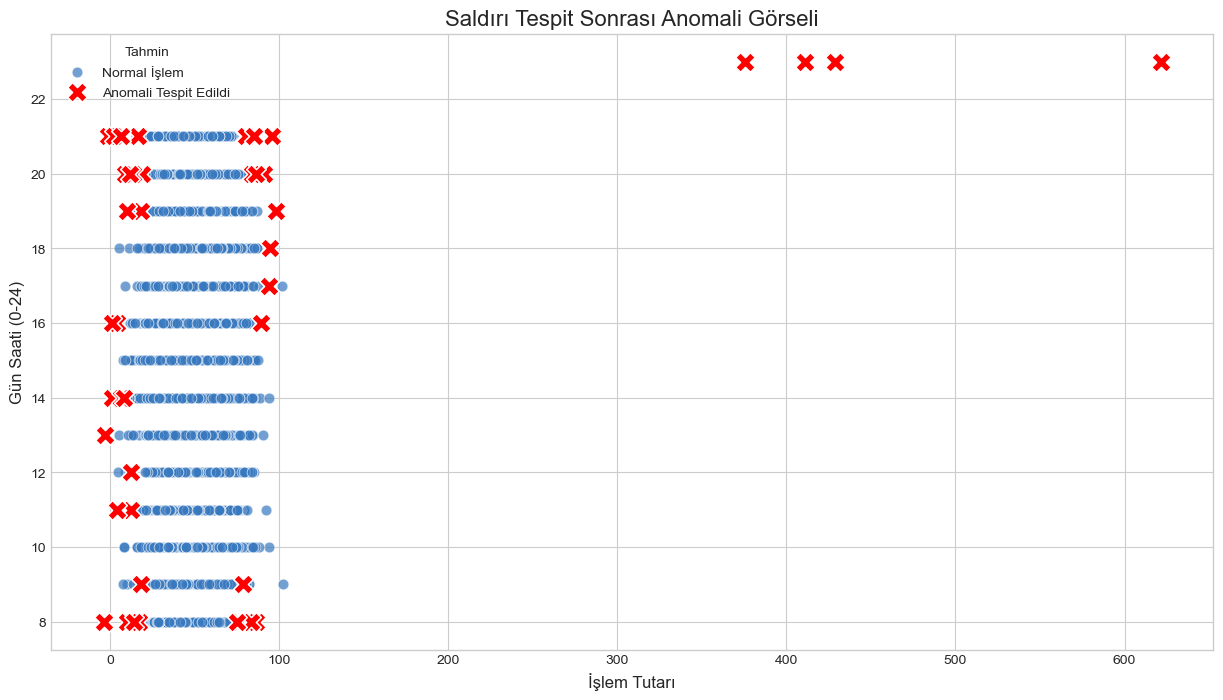


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:23
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
56856  621.33           23          203         1                  -1
57312  375.70           23          202         1                  -1
57890  429.03           23          203         1                  -1
58553  410.83           23          201         1                  -1
60818  307.64            2          208         1                  -1
60830  735.79           23          202         1                  -1


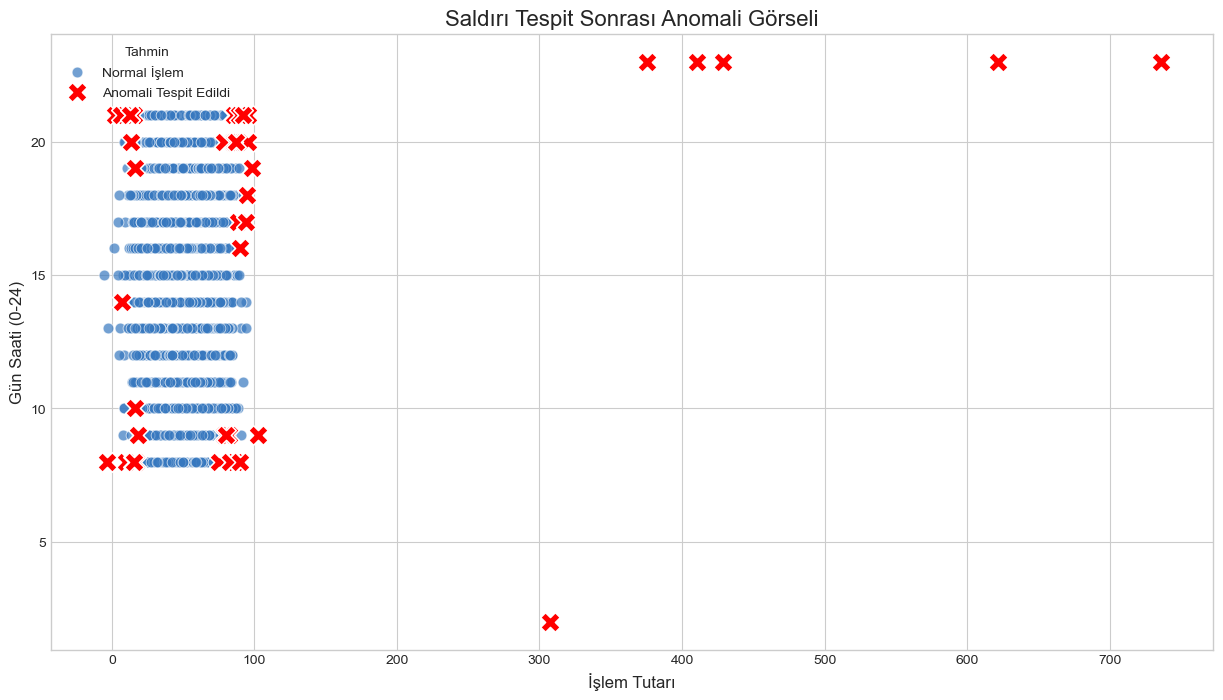


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:25
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
58553  410.83           23          201         1                  -1
60818  307.64            2          208         1                  -1
60830  735.79           23          202         1                  -1


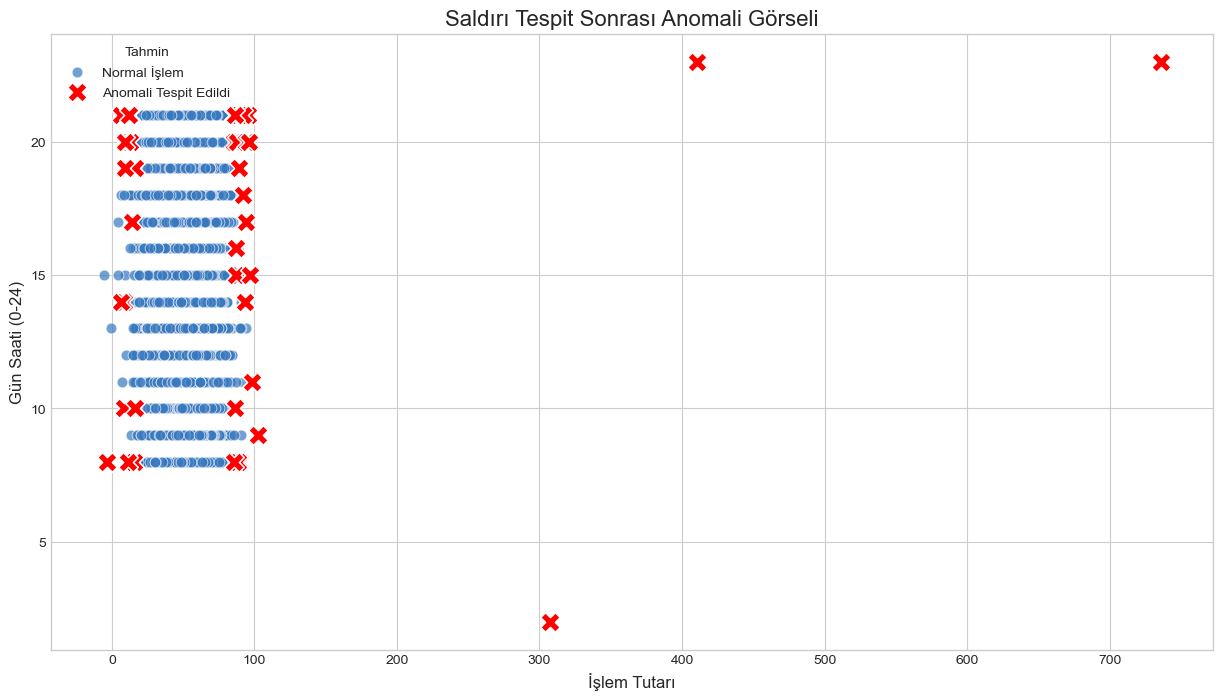


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:28
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
60818  307.64            2          208         1                  -1
60830  735.79           23          202         1                  -1
63589  493.39            2          203         1                  -1
64576  512.82            2          204         1                  -1
64600  563.77           23          205         1                  -1
64613  395.94            2          208         1                  -1
64641  528.43            2          202         1                  -1


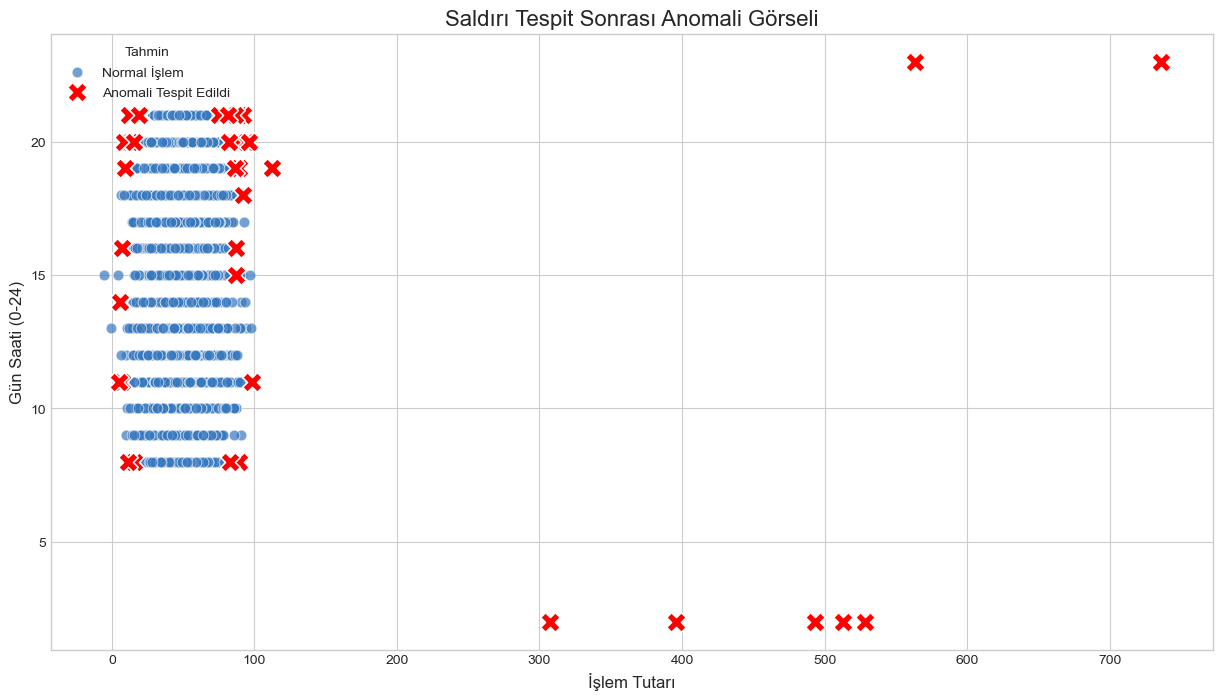


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:30
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
63589  493.39            2          203         1                  -1
64576  512.82            2          204         1                  -1
64600  563.77           23          205         1                  -1
64613  395.94            2          208         1                  -1
64641  528.43            2          202         1                  -1


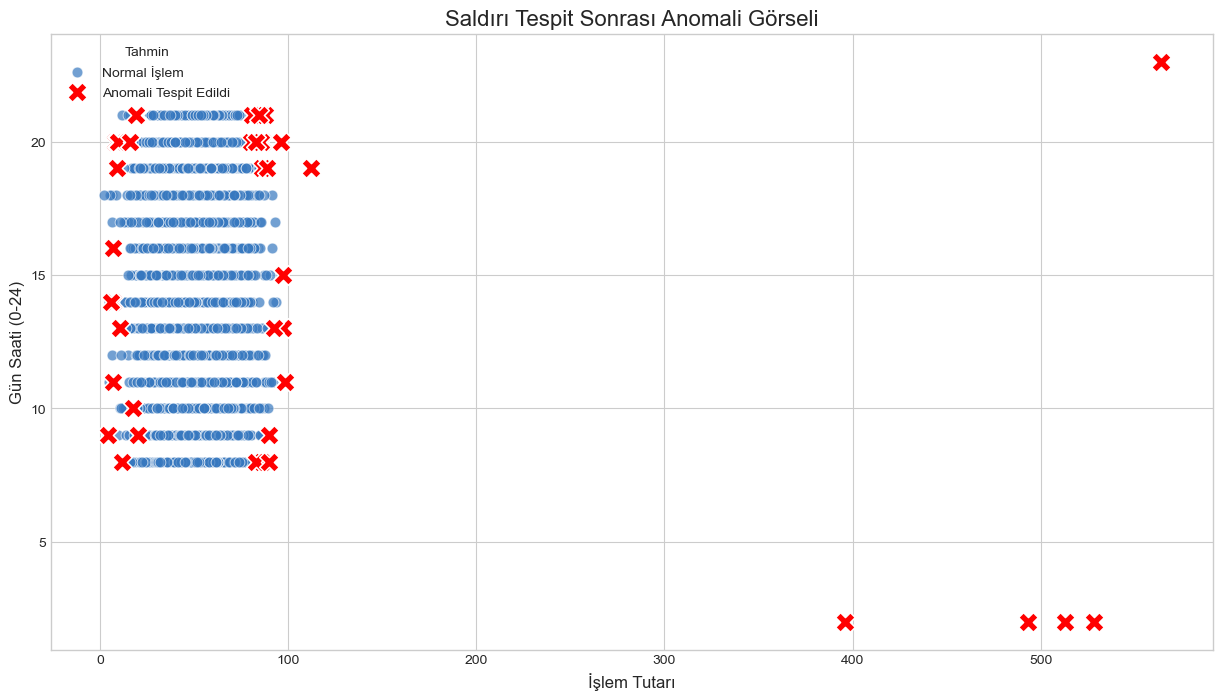


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:32
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
63589  493.39            2          203         1                  -1
64576  512.82            2          204         1                  -1
64600  563.77           23          205         1                  -1
64613  395.94            2          208         1                  -1
64641  528.43            2          202         1                  -1
67091  353.84            2          207         1                  -1


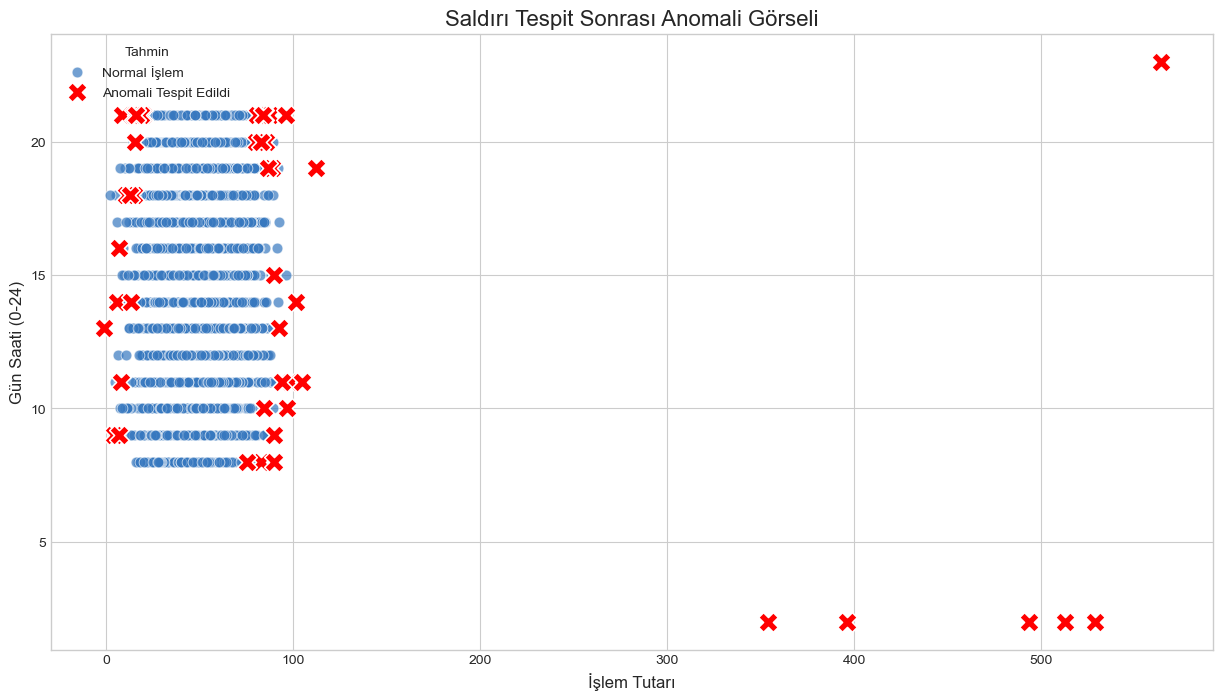


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:35
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
67091  353.84            2          207         1                  -1
68646  573.78            2          206         1                  -1


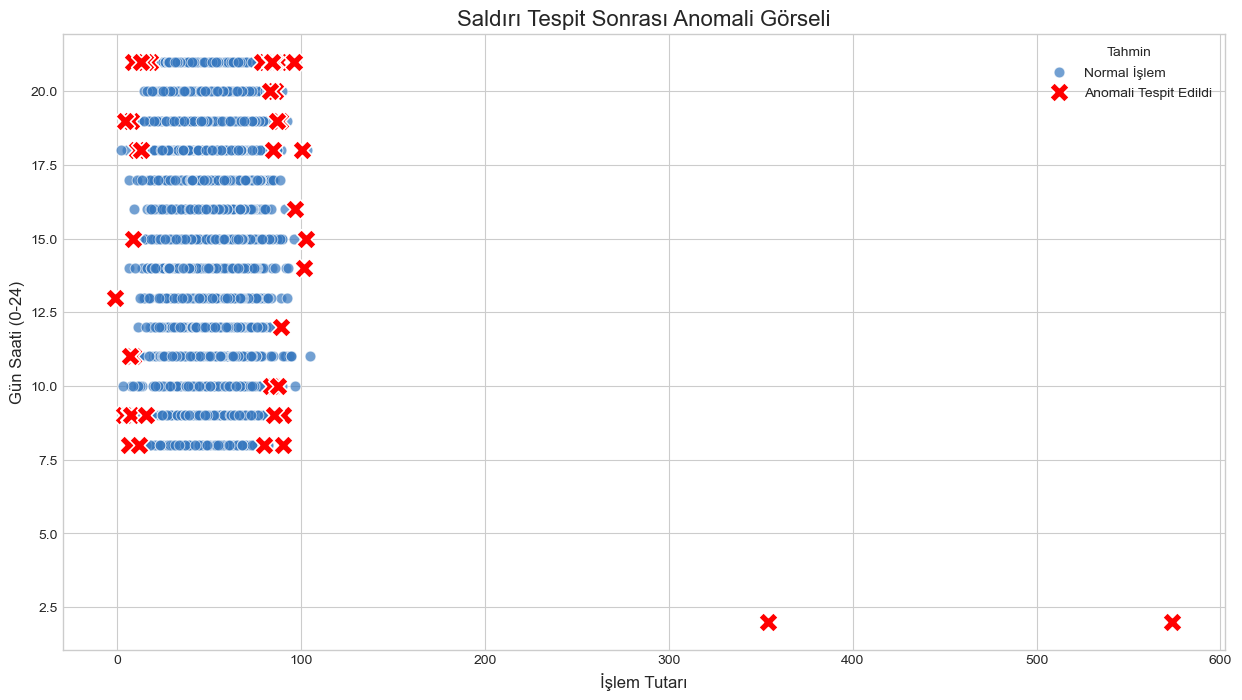


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:37
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
67091  353.84            2          207         1                  -1
68646  573.78            2          206         1                  -1
71310  455.57            2          202         1                  -1
71580  748.18           23          202         1                  -1


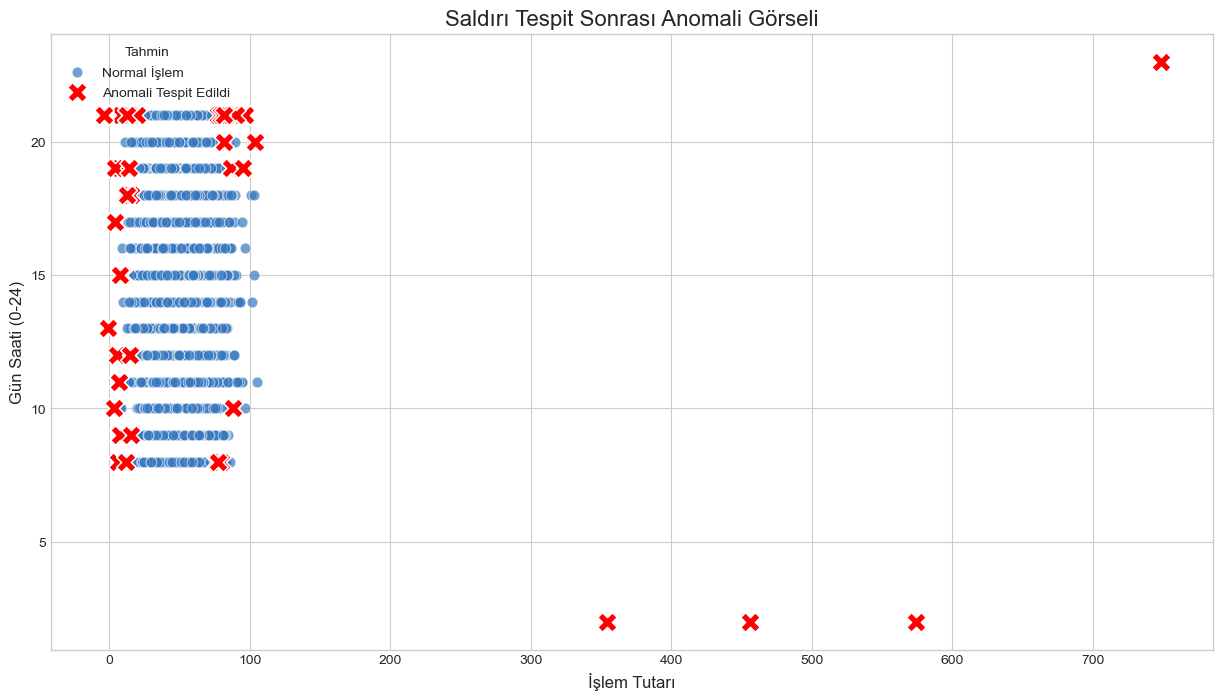


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:40
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
68646  573.78            2          206         1                  -1
71310  455.57            2          202         1                  -1
71580  748.18           23          202         1                  -1
72310  663.55           23          209         1                  -1


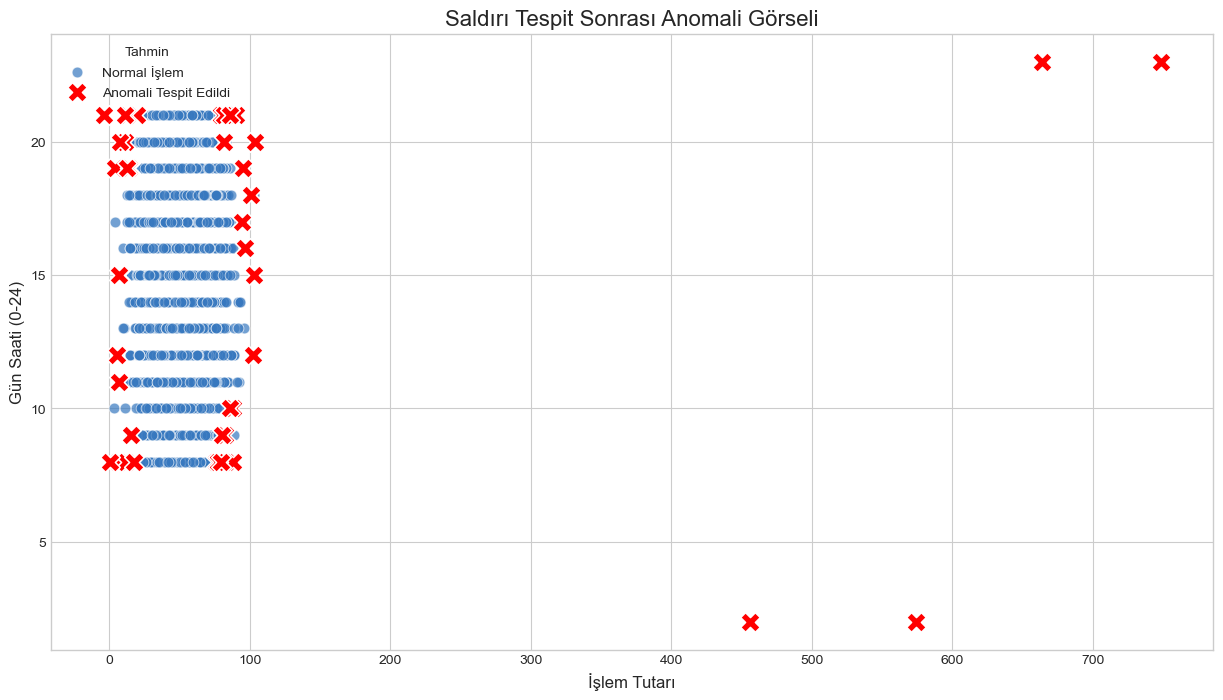


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:42
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
71310  455.57            2          202         1                  -1
71580  748.18           23          202         1                  -1
72310  663.55           23          209         1                  -1


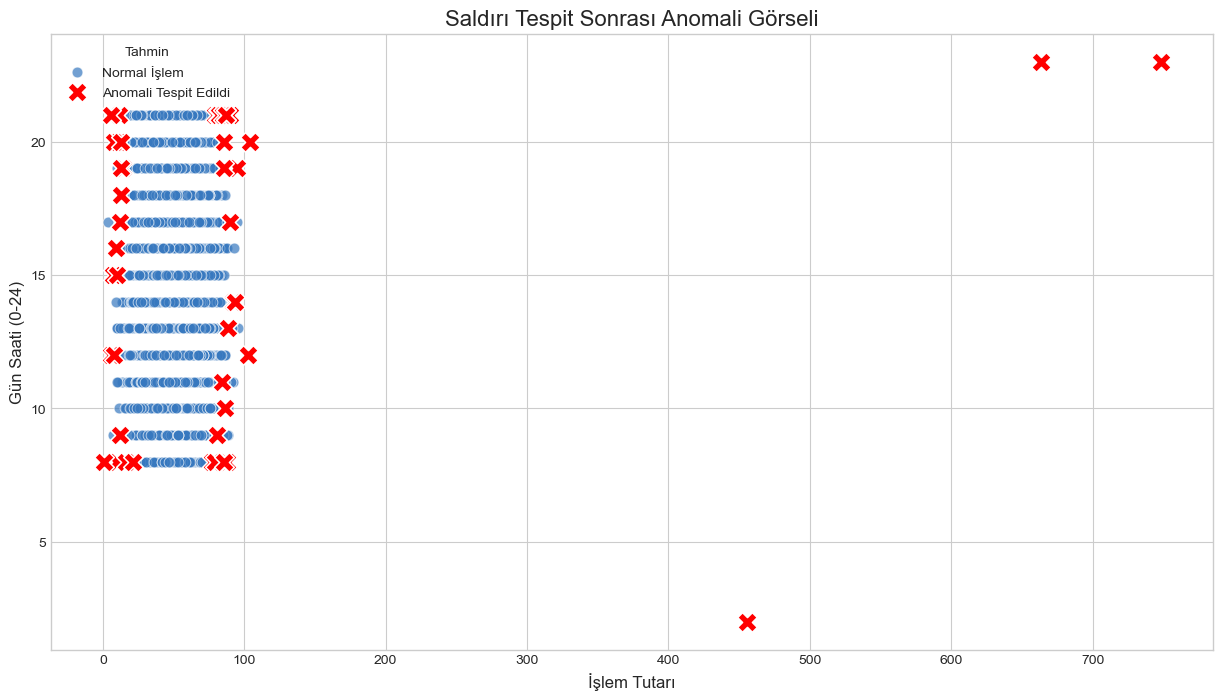


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:44
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
72310  663.55           23          209         1                  -1
76035  418.94            2          209         1                  -1
76644  550.73           23          200         1                  -1


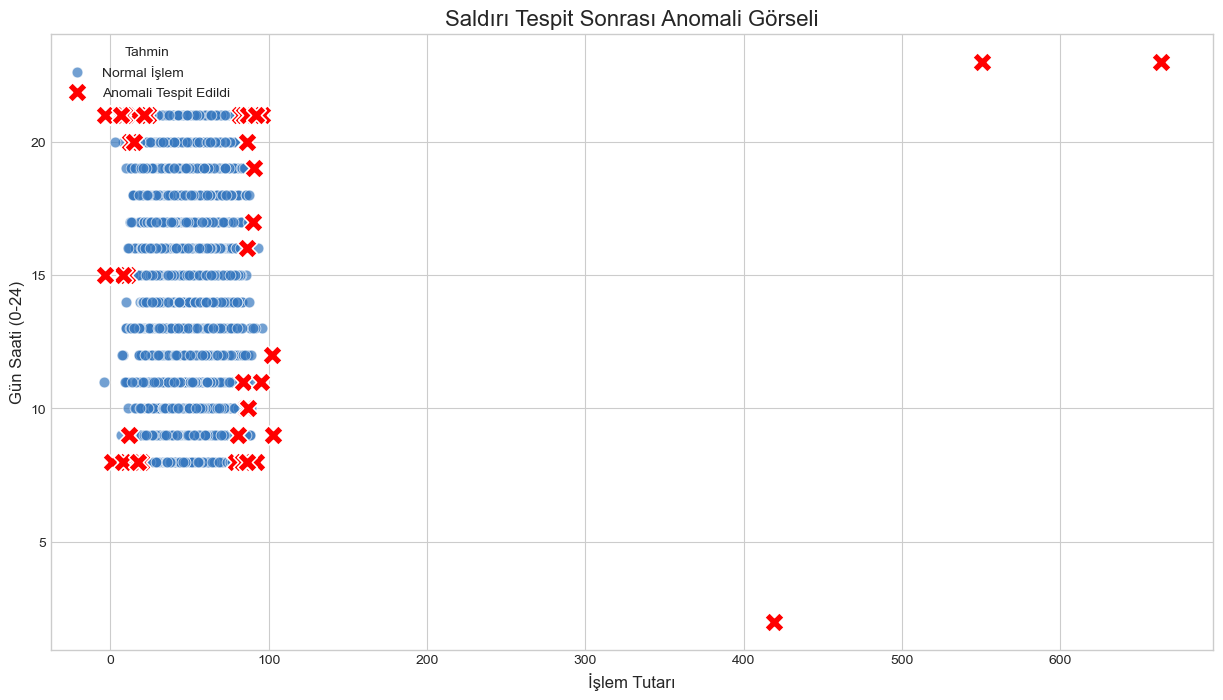


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:46
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
76035  418.94            2          209         1                  -1
76644  550.73           23          200         1                  -1


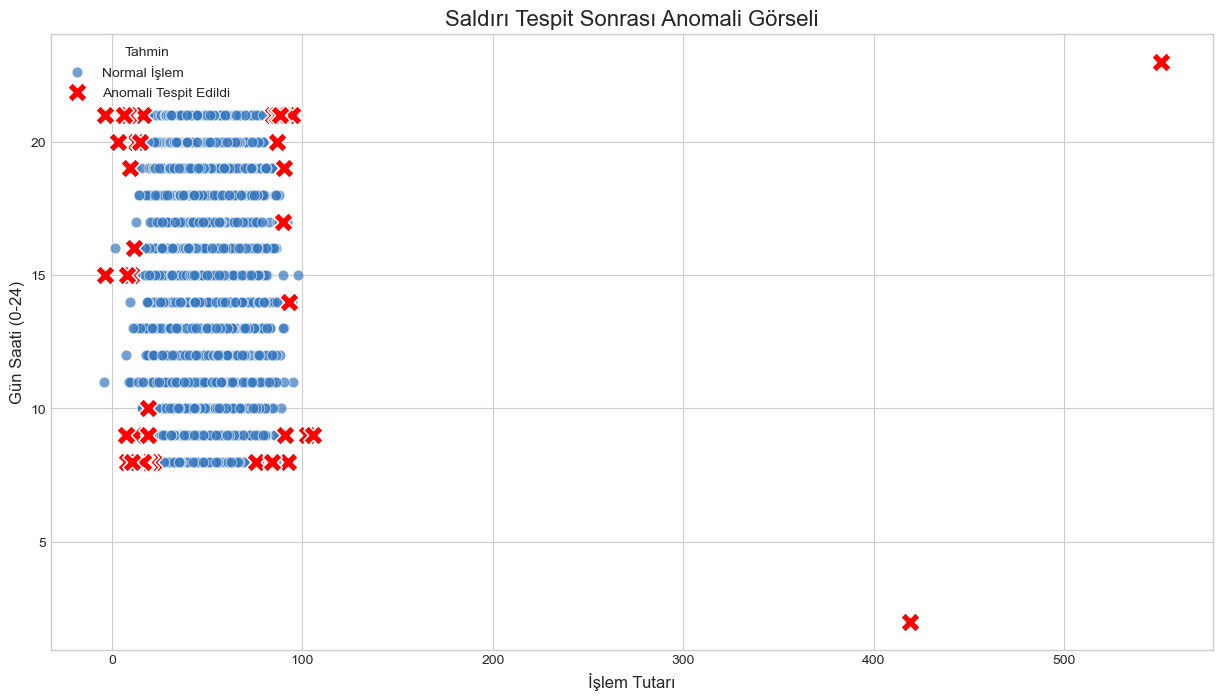


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:49
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
76035  418.94            2          209         1                  -1
76644  550.73           23          200         1                  -1
79260  503.63            2          204         1                  -1
79658  305.14           23          207         1                  -1


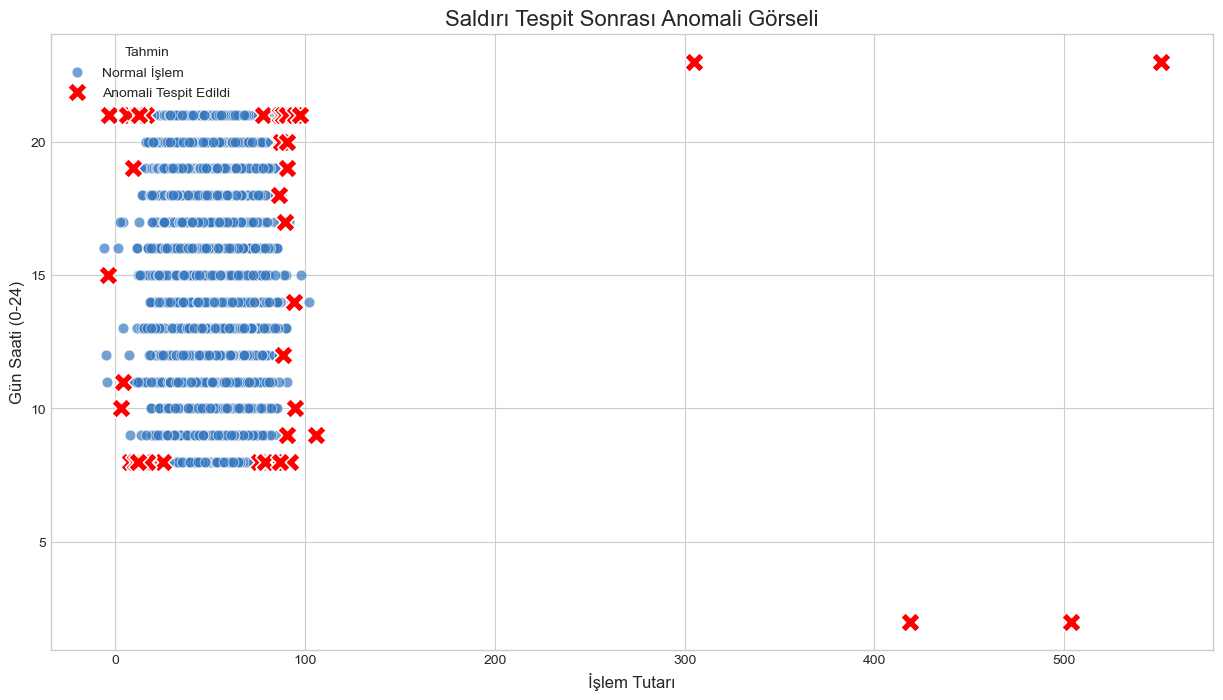


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:51
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
79260  503.63            2          204         1                  -1
79658  305.14           23          207         1                  -1
82175  490.40            2          208         1                  -1


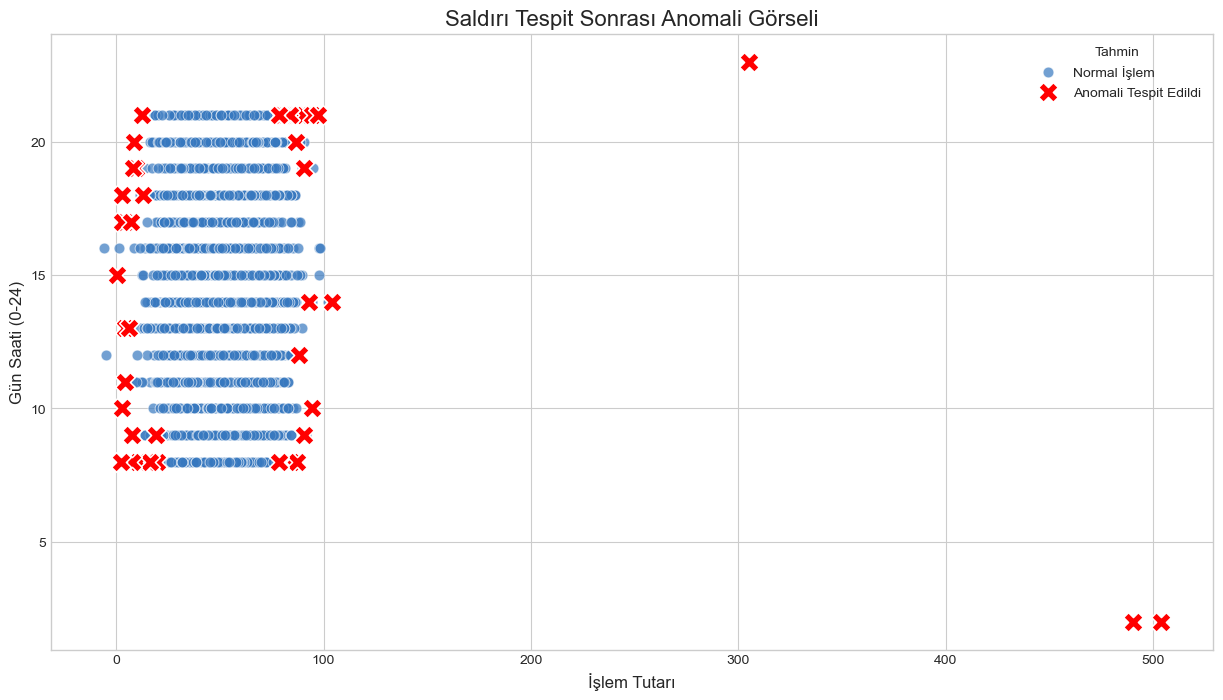


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:53
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
79260  503.63            2          204         1                  -1
79658  305.14           23          207         1                  -1
82175  490.40            2          208         1                  -1
83128  427.83           23          205         1                  -1
83470  493.63            2          203         1                  -1
83932  481.99           23          205         1                  -1


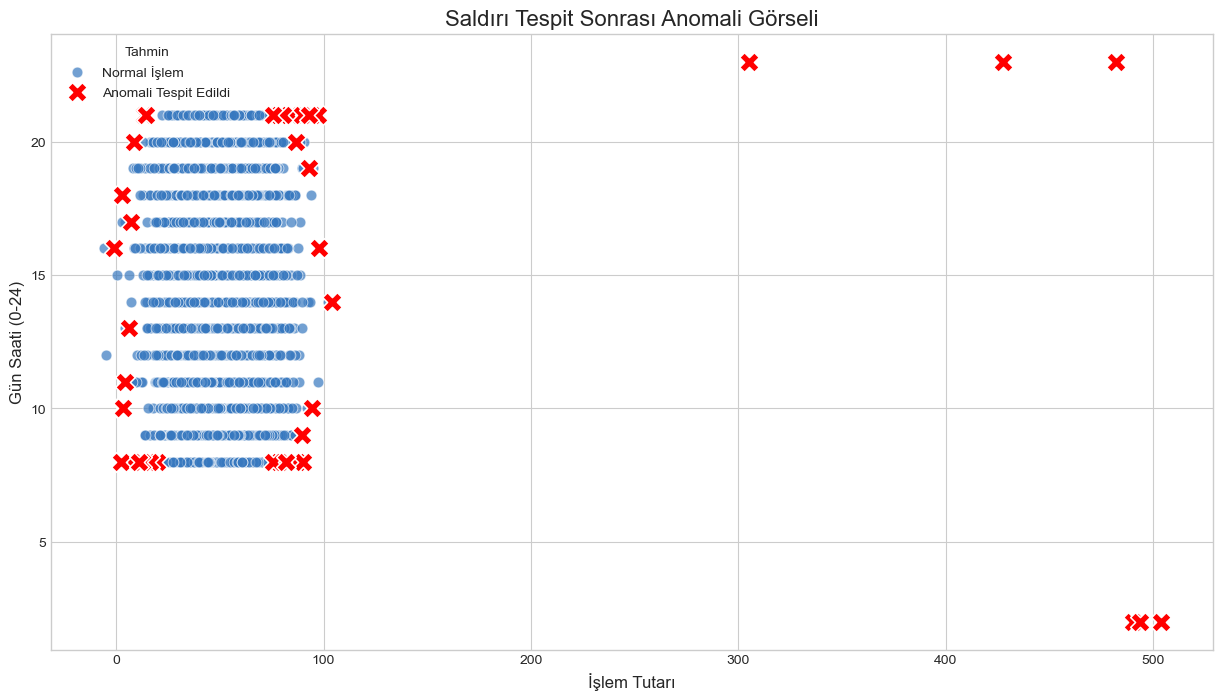


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:56
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
82175  490.40            2          208         1                  -1
83128  427.83           23          205         1                  -1
83470  493.63            2          203         1                  -1
83932  481.99           23          205         1                  -1


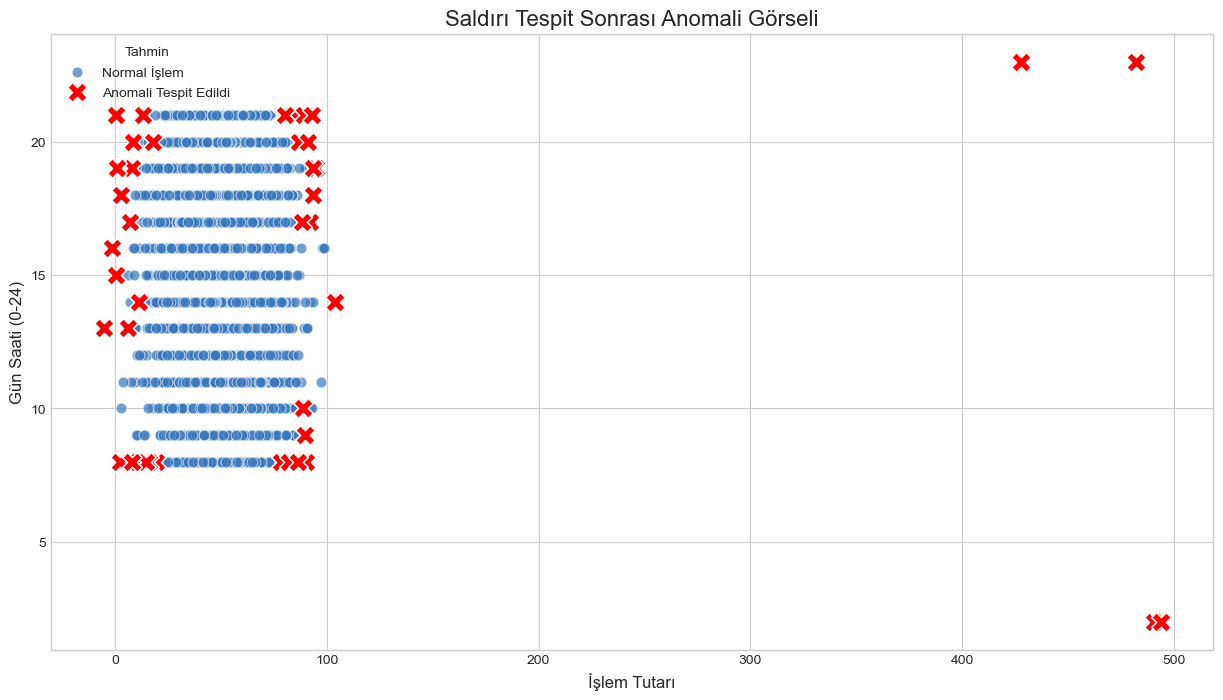


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:20:58
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
83128  427.83           23          205         1                  -1
83470  493.63            2          203         1                  -1
83932  481.99           23          205         1                  -1


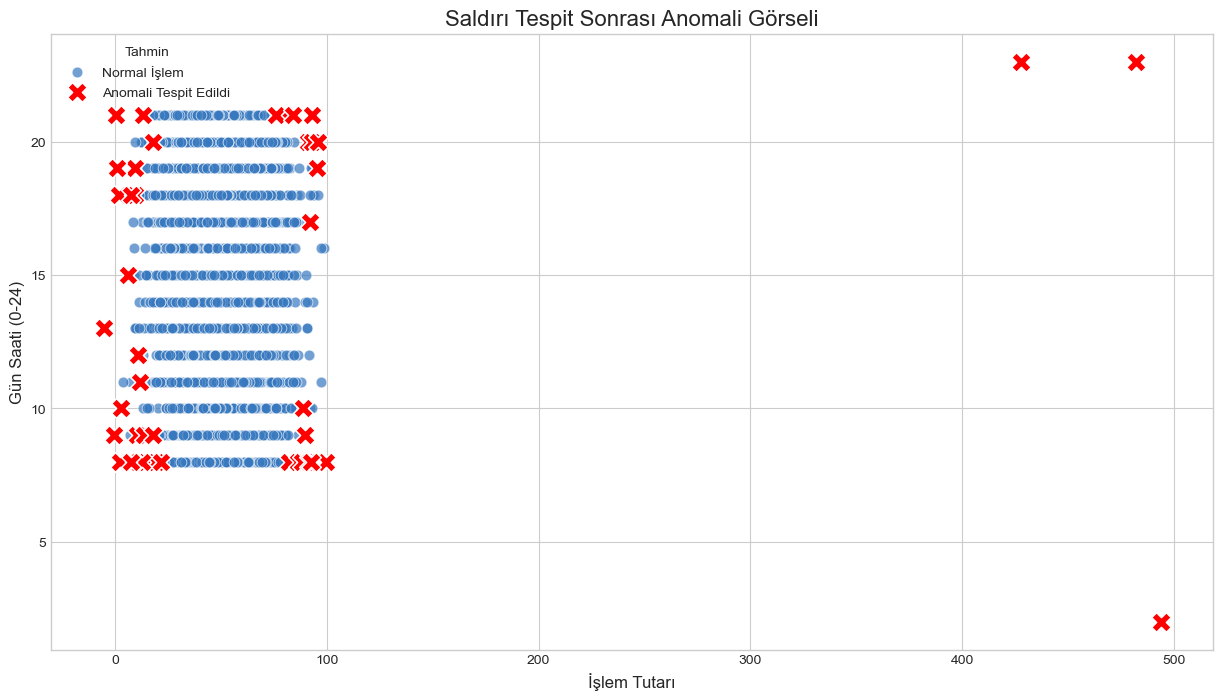


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:00
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
88239  557.85           23          202         1                  -1
89160  591.34           23          203         1                  -1


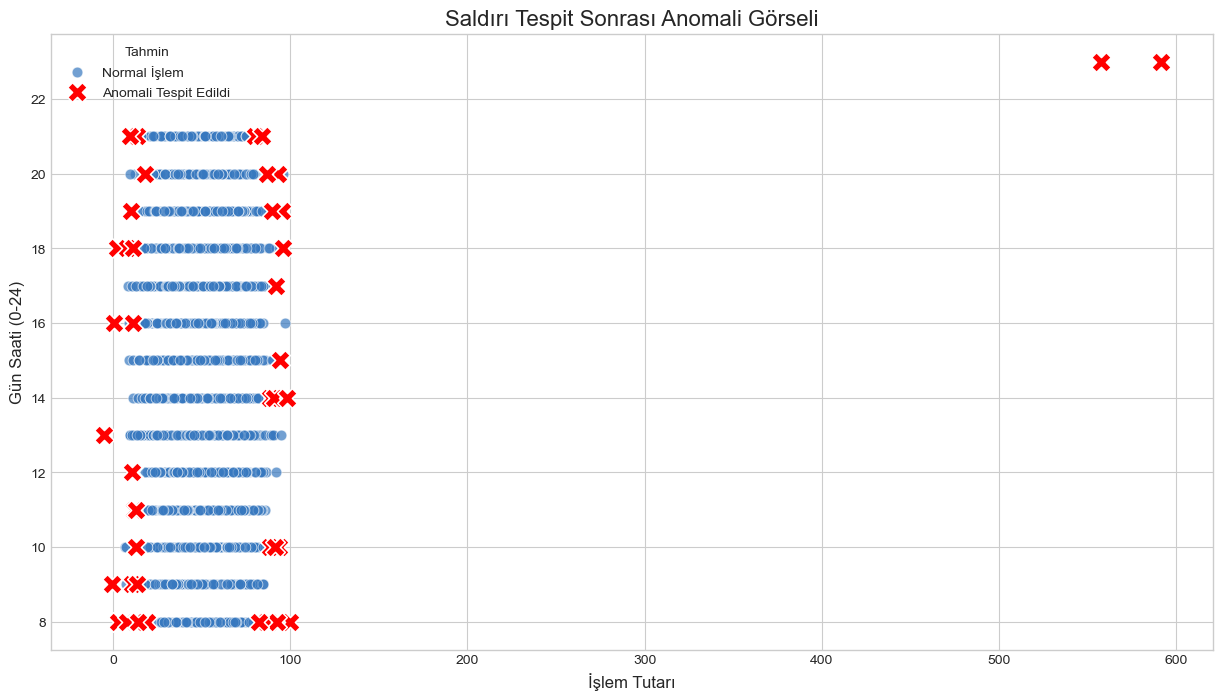


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:03
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
88239  557.85           23          202         1                  -1
89160  591.34           23          203         1                  -1
90877  532.47           23          206         1                  -1


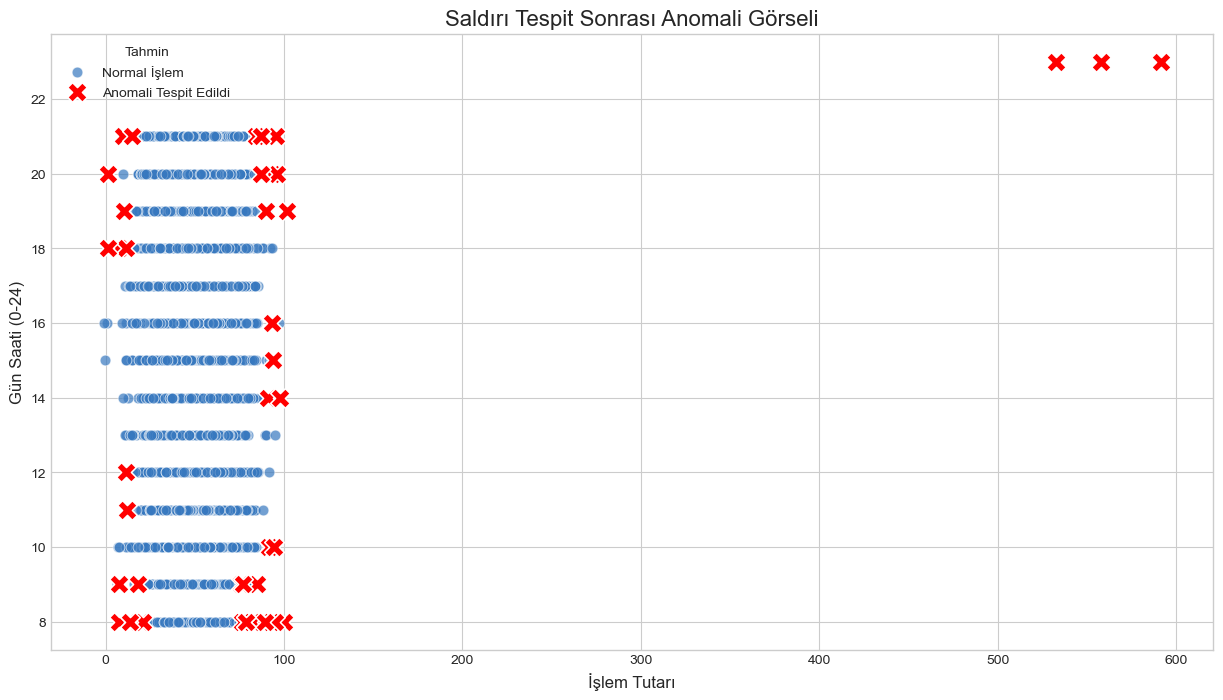


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:05
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
88239  557.85           23          202         1                  -1
89160  591.34           23          203         1                  -1
90877  532.47           23          206         1                  -1
91882  402.21           23          205         1                  -1
92876  706.20           23          200         1                  -1


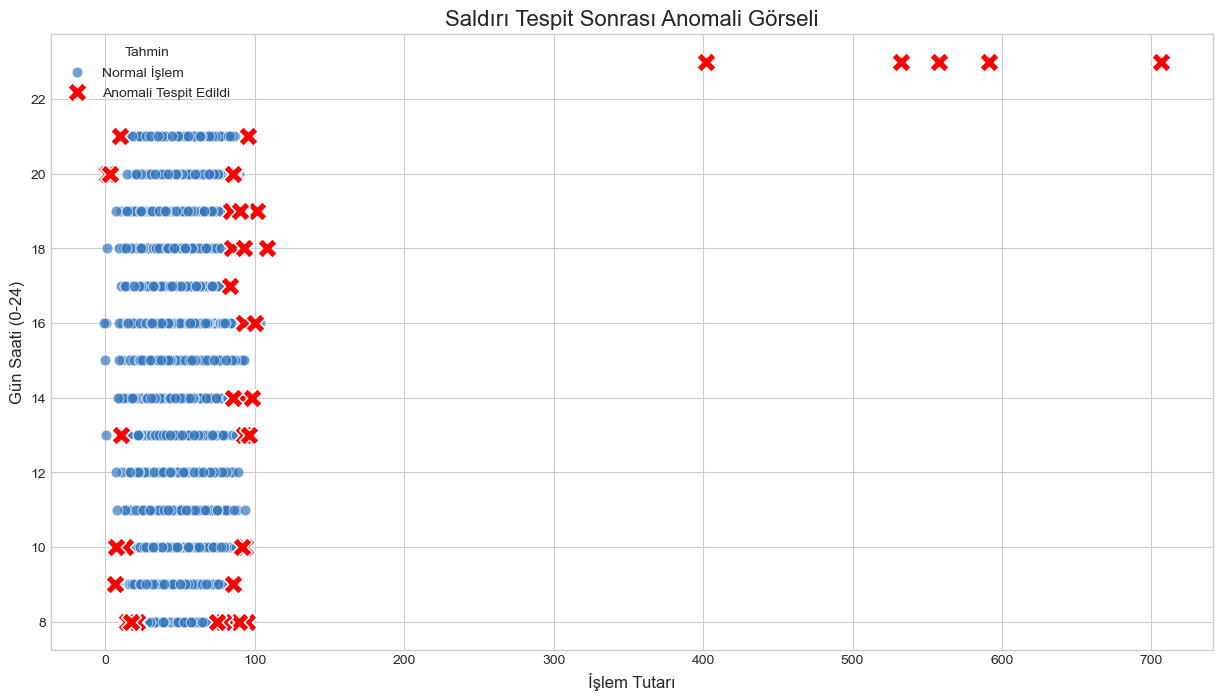


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:07
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
90877  532.47           23          206         1                  -1
91882  402.21           23          205         1                  -1
92876  706.20           23          200         1                  -1
93357  478.53            2          201         1                  -1


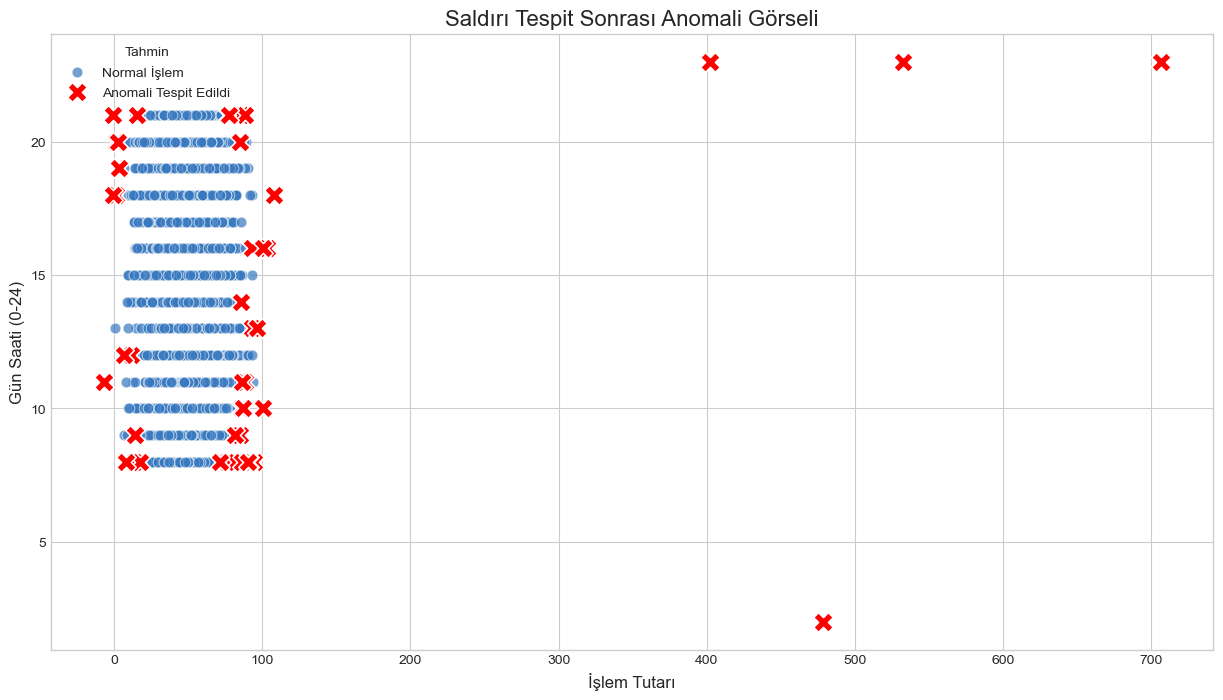


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:10
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
91882  402.21           23          205         1                  -1
92876  706.20           23          200         1                  -1
93357  478.53            2          201         1                  -1
95446  485.49           23          208         1                  -1


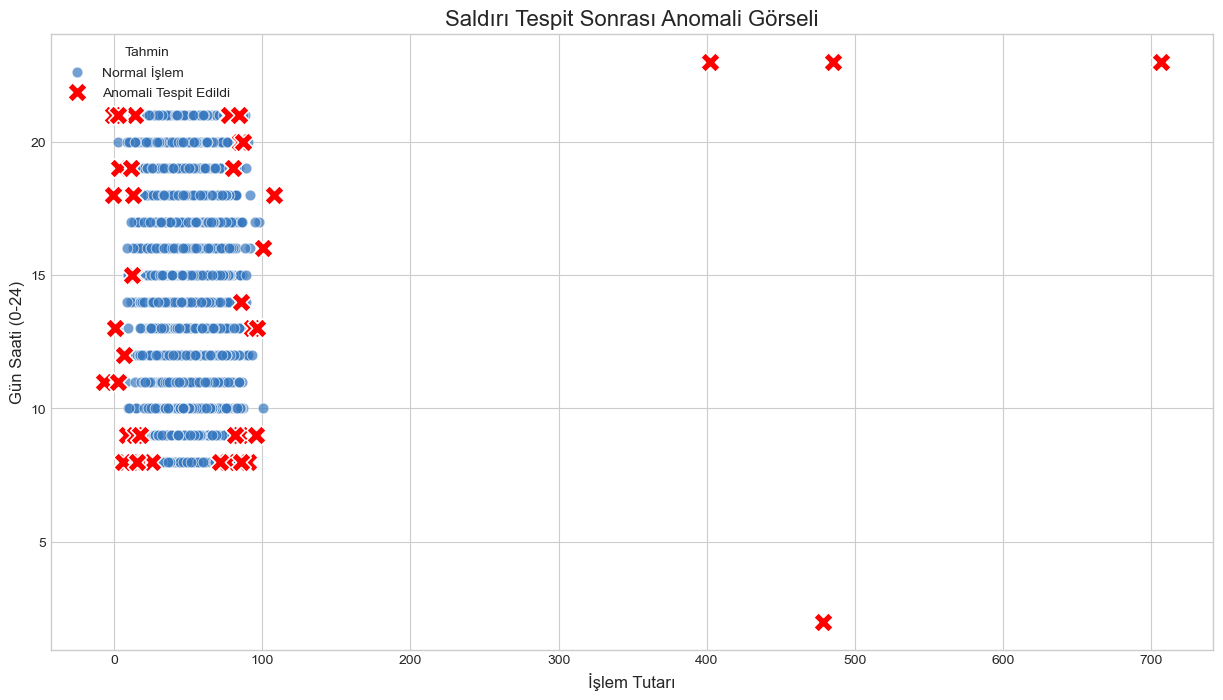


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:12
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
93357  478.53            2          201         1                  -1
95446  485.49           23          208         1                  -1
97181  389.48           23          208         1                  -1
97502  635.24            2          202         1                  -1


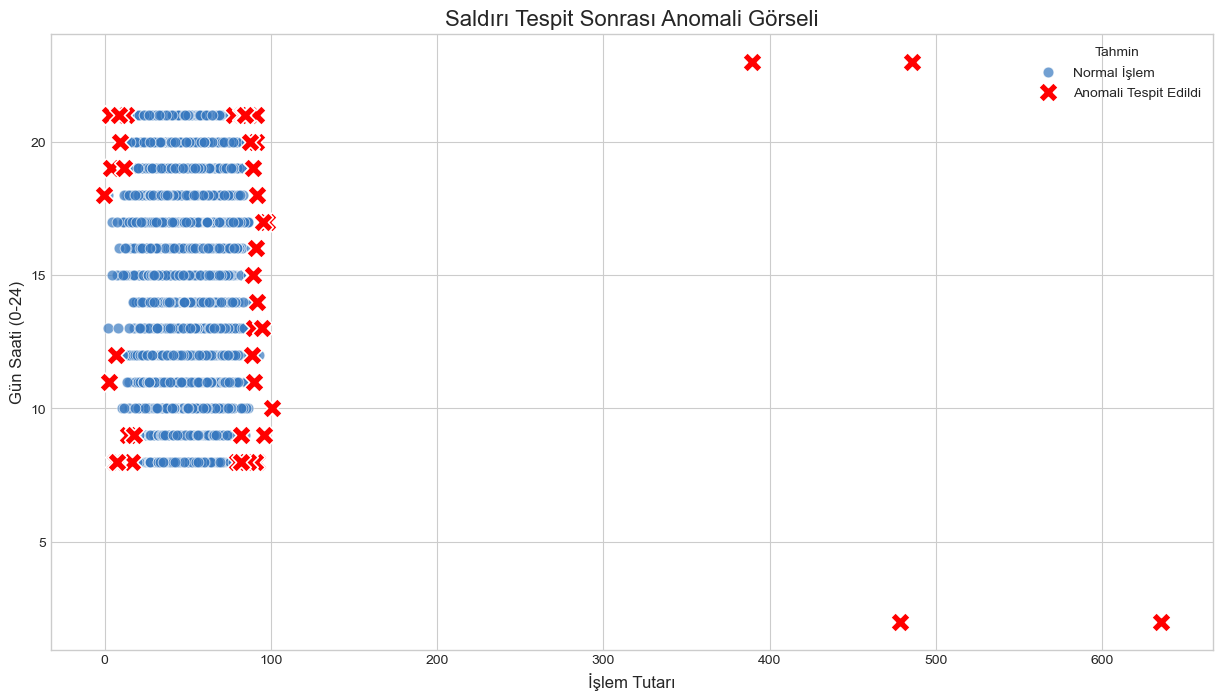


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:14
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
95446  485.49           23          208         1                  -1
97181  389.48           23          208         1                  -1
97502  635.24            2          202         1                  -1
99668  594.00           23          203         1                  -1
Sanal veri üretimi tamamlandı.


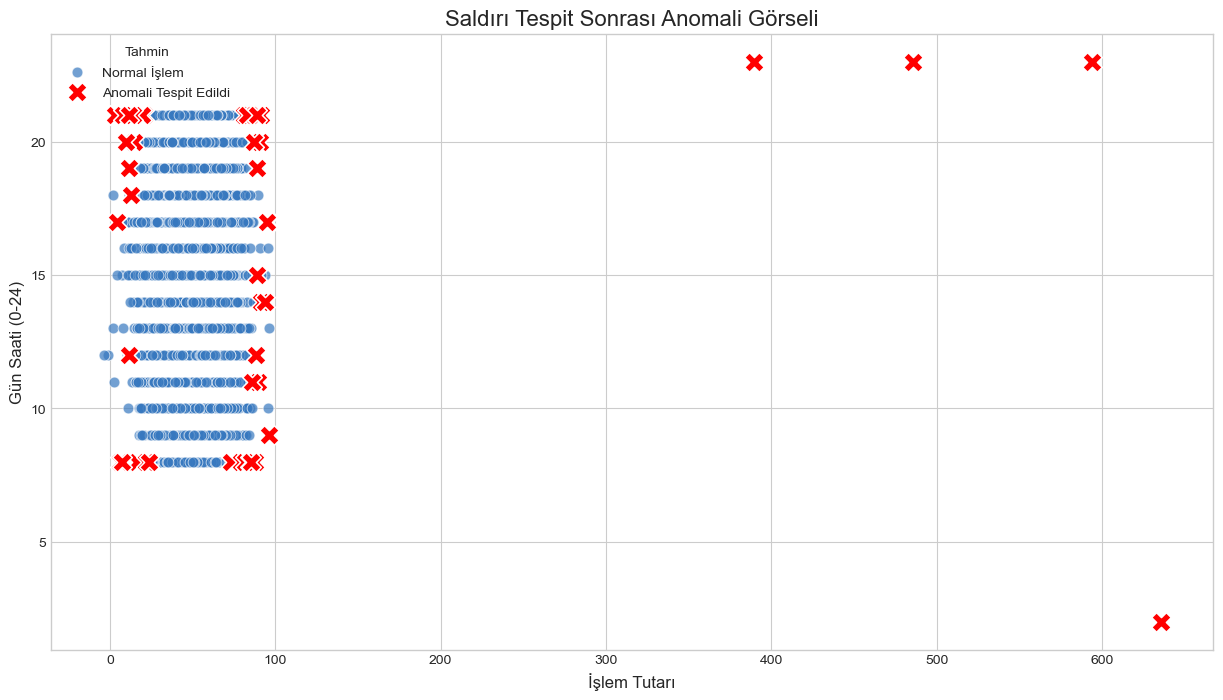


!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!
Tespit Zamanı: 2025-08-04 22:21:17
--- Anomali Detayları ---
       amount  time_of_day  terminal_id  is_fraud  anomaly_prediction
95446  485.49           23          208         1                  -1
97181  389.48           23          208         1                  -1
97502  635.24            2          202         1                  -1
99668  594.00           23          203         1                  -1


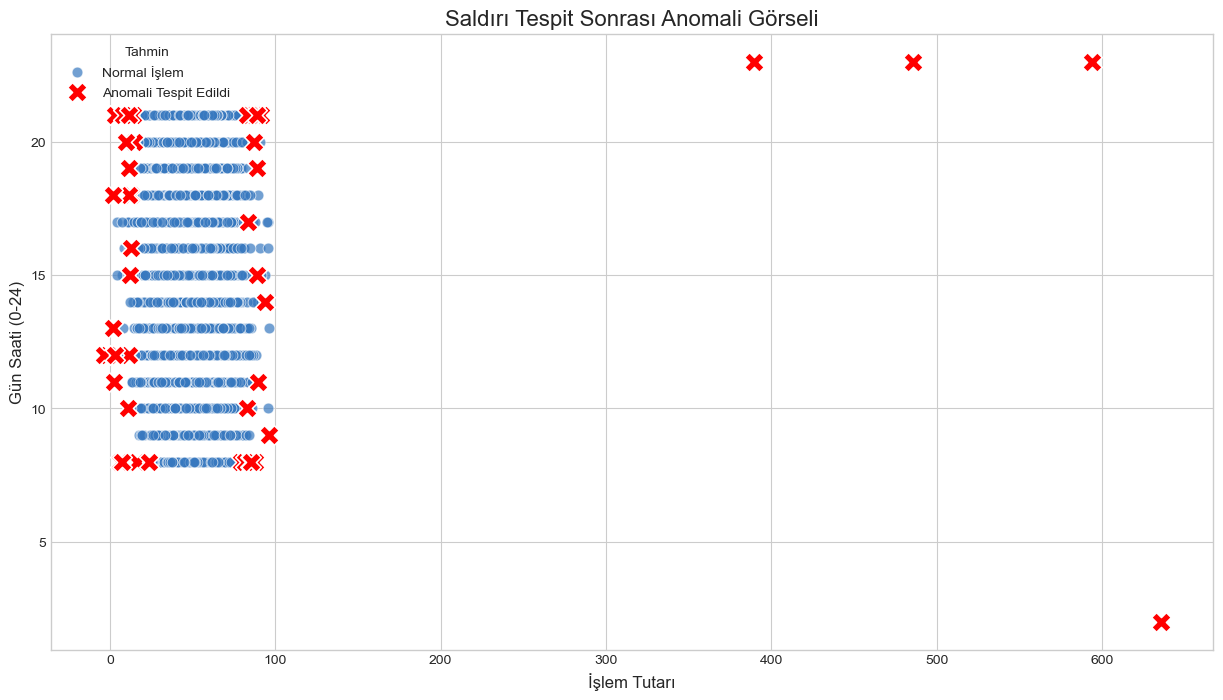


--- Proje Sonuçları ---
Toplam işlem sayısı: 100050
Toplam gerçek dolandırıcılık sayısı: 138
Model tarafından tespit edilen anomali sayısı: 1011
Doğru tespit edilen dolandırıcılık (True Positive): 137
Yanlış tespit edilen dolandırıcılık (False Positive): 874
--- Proje sonu ---


In [4]:
import pandas as pd
import numpy as np
import time
import threading
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# --- Adım 1: Sanal Veri Akışını Başlatma ---
# Global değişkenler
transaction_data = []
is_running = True
lock = threading.Lock() 

def generate_transactions(total_transactions, fraud_rate=0.001):
    """
    Sanal POS işlemlerini (normal ve sahte) sürekli üreten bir fonksiyon.
    100.000 adet veri oluşturulacak.
    """
    global transaction_data
    np.random.seed(42)
    print("--- 1. Sanal POS Sistemi Başlatıldı ---")
    print(f"Toplam {total_transactions} adet işlem verisi oluşturuluyor...")
    
    for i in range(total_transactions):
        with lock:
            # Normal işlem
            amount = np.random.normal(loc=50, scale=15)
            time_of_day = np.random.randint(8, 22)
            terminal_id = np.random.randint(100, 110)
            is_fraud = 0

            # Küçük bir ihtimalle sahte işlem oluştur
            if np.random.rand() < fraud_rate: 
                amount = np.random.normal(loc=500, scale=100)
                time_of_day = np.random.choice([2, 23])
                terminal_id = np.random.randint(200, 210)
                is_fraud = 1
            
            transaction_data.append({
                'amount': round(amount, 2),
                'time_of_day': time_of_day,
                'terminal_id': terminal_id,
                'is_fraud': is_fraud
            })
        
        time.sleep(0.001) # Daha hızlı veri üretimi
    
    print("Sanal veri üretimi tamamlandı.")


def simulate_attack(attack_start_time):
    """
    Belirli bir süre sonra bir RAM scraping saldırısını simüle eder.
    """
    global transaction_data
    print(f"\n--- Saldırı Simülasyonu Başlatılıyor ---")
    print(f"Saldırı, {attack_start_time} saniye sonra başlayacak.")
    time.sleep(attack_start_time)
    
    print("\n!!! RAM SCRAPING SALDIRISI BAŞLADI !!!")
    for _ in range(50): # 50 sahte işlem
        with lock:
            transaction_data.append({
                'amount': np.random.normal(loc=1500, scale=200),
                'time_of_day': np.random.randint(10, 15),
                'terminal_id': 105,
                'is_fraud': 1
            })
        time.sleep(0.05)
    print("Saldırı tamamlandı.")

# --- Görselleştirme Fonksiyonları ---
def plot_data_distribution(df, title="Veri Dağılımı"):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df['amount'], bins=30, ax=axes[0], kde=True, color='skyblue')
    axes[0].set_title('İşlem Tutarı Dağılımı', fontsize=14)
    axes[0].set_xlabel('İşlem Tutarı', fontsize=12)

    sns.histplot(df['time_of_day'], bins=24, ax=axes[1], kde=False, color='salmon')
    axes[1].set_title('Gün Saati Dağılımı', fontsize=14)
    axes[1].set_xlabel('Gün Saati (0-24)', fontsize=12)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_anomalies(df, title="Anomali Tespit Sonuçları"):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    sns.scatterplot(
        x='amount', y='time_of_day', data=df[df['anomaly_prediction'] == 1],
        color='#3778bf', s=60, alpha=0.7, label='Normal İşlem'
    )

    anomalies = df[df['anomaly_prediction'] == -1]
    sns.scatterplot(
        x='amount', y='time_of_day', data=anomalies,
        color='red', marker='X', s=200, label='Anomali Tespit Edildi'
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel('İşlem Tutarı', fontsize=12)
    plt.ylabel('Gün Saati (0-24)', fontsize=12)
    plt.legend(title='Tahmin')
    plt.show()

# --- Ana Proje Döngüsü ---
def main():
    global transaction_data, is_running
    
    # 100.000 adet veri üretimi için thread başlatma
    transaction_thread = threading.Thread(target=generate_transactions, args=(20000,))
    transaction_thread.start()
    
    # 60 saniye sonra başlayacak saldırı simülasyonu
    attack_thread = threading.Thread(target=simulate_attack, args=(60,))
    attack_thread.start()

    all_data = pd.DataFrame()
    model = None
    scaler = StandardScaler()
    
    print("\n--- 2. Dijital İkiz Modeli Oluşturuluyor ---")
    print("Gelen verilerle model sürekli güncelleniyor. Lütfen bekleyin...")
    
    while transaction_thread.is_alive() or attack_thread.is_alive() or is_running:
        new_transactions = []
        with lock:
            if transaction_data:
                new_transactions = transaction_data[:]
                transaction_data.clear()
        
        if new_transactions:
            new_df = pd.DataFrame(new_transactions)
            all_data = pd.concat([all_data, new_df], ignore_index=True)
            
            window_size = 5000 # Kayan pencere boyutunu büyüttük
            if len(all_data) > window_size:
                recent_data = all_data.tail(window_size).copy()
            else:
                recent_data = all_data.copy()

            if not recent_data.empty and len(recent_data) > 100: # Yeterli veri varsa modeli eğit
                features = ['amount', 'time_of_day', 'terminal_id']
                X = recent_data[features]
                
                X_scaled = scaler.fit_transform(X)
                
                if len(all_data) < 50000 and len(all_data) % 10000 == 0:
                    plot_data_distribution(all_data, f"Adım: {len(all_data)} İşlem Sonrası Veri Dağılımı")
                
                # contamination parametresini manuel olarak belirledik
                model = IsolationForest(contamination=0.01, random_state=42)
                model.fit(X_scaled)
                
                recent_data['anomaly_prediction'] = model.predict(X_scaled)
                all_data.loc[recent_data.index, 'anomaly_prediction'] = recent_data['anomaly_prediction']
                
                anomalies = recent_data[(recent_data['anomaly_prediction'] == -1) & (recent_data['is_fraud'] == 1)]
                
                if not anomalies.empty:
                    print("\n" + "="*50)
                    print(f"!!! GERÇEK ZAMANLI ANOMALİ TESPİT EDİLDİ !!!")
                    print(f"Tespit Zamanı: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
                    print("--- Anomali Detayları ---")
                    print(anomalies)
                    print("="*50)
                    plot_anomalies(recent_data, "Saldırı Tespit Sonrası Anomali Görseli")

        if not transaction_thread.is_alive() and not attack_thread.is_alive() and not transaction_data:
            is_running = False
            
        time.sleep(2)

    print("\n--- Proje Sonuçları ---")
    print(f"Toplam işlem sayısı: {len(all_data)}")
    
    real_frauds = all_data[all_data['is_fraud'] == 1]
    print(f"Toplam gerçek dolandırıcılık sayısı: {len(real_frauds)}")
    
    # 'anomaly_prediction' sütunu NaN değerler içeriyorsa doldur
    all_data['anomaly_prediction'] = all_data['anomaly_prediction'].fillna(1).astype(int)
    
    detected_anomalies = all_data[all_data['anomaly_prediction'] == -1]
    
    true_positives = len(detected_anomalies[detected_anomalies['is_fraud'] == 1])
    false_positives = len(detected_anomalies[detected_anomalies['is_fraud'] == 0])
    
    print(f"Model tarafından tespit edilen anomali sayısı: {len(detected_anomalies)}")
    print(f"Doğru tespit edilen dolandırıcılık (True Positive): {true_positives}")
    print(f"Yanlış tespit edilen dolandırıcılık (False Positive): {false_positives}")
    print("--- Proje sonu ---")

if __name__ == "__main__":
    main()